# Notebook for plotting figures

This notebook is for generating and saving plots. See the other notebook `2019-10-22_oceans-conf-paper-plot.ipynb` for details of analysis.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import datetime
import h5py
import pandas as pd
import xarray as xr
import tensorly as tl

## Load and inspect data

In [2]:
# print('There are a total of %d pings per hour.' % (20*60/5))  # Number of pings per hour

### Calibrated MVBS data

Here we first inspect the calibrated mean volume backscattering strength (MVBS, or $\overline{\textrm{S}_\textrm{V}}$) already pre-processed from the raw data.
The raw data were obtained from the Ocean Observatories Initiative (OOI) Raw Data 
Archive, from the Oregon Offshore Cabled Shallow Profiler Mooring (CE04OSPS).
All other info can be found in the paper.

In [3]:
# Set up paths
MVBS_raw_path = '../sample_data/'
MVBS_raw_fname = '20150817-20151017_MVBS.h5'
fig_save_path = './figs_2019_paper/'

In [4]:
# Load raw MVBS data
f_raw = h5py.File(os.path.join(MVBS_raw_path,MVBS_raw_fname),'r')
MVBS_raw = np.array(f_raw['MVBS'])
depth_bin_size = np.array(f_raw['depth_bin_size'])
ping_time = np.array(f_raw['ping_time'])
f_raw.close()

Let's first inspect the dimension of the data:

In [5]:
echoes_mvbs = []
for f in range(3):
    echoes_mvbs.append(MVBS_raw[f,37:0:-1,:])

Let's contruct an xarray DataArray for the MVBS data to make plotting easier:

In [6]:
frequency = np.array([38000,120000,200000])
p_time = pd.to_datetime(mdates.num2date(ping_time)).tz_convert(None)
depth = (np.arange(37)+1)*depth_bin_size
MVBS = xr.DataArray(np.array(echoes_mvbs), 
                    coords=[('frequency', frequency), 
                            ('depth', depth), 
                            ('ping_time', p_time)])

In [7]:
def plot_3_echograms(da):
    fig,ax = plt.subplots(3,1,figsize=(14,5),sharex=True)
    im = da.sel(frequency=38000).\
        plot(ax=ax[0], vmin=-80, vmax=-40, cmap='Spectral_r', add_colorbar=False, yincrease=False)
    da.sel(frequency=120000).\
        plot(ax=ax[1], vmin=-80, vmax=-40, cmap='Spectral_r', add_colorbar=False, yincrease=False)
    da.sel(frequency=200000).\
        plot(ax=ax[2], vmin=-80, vmax=-40, cmap='Spectral_r', add_colorbar=False, yincrease=False)
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=range(0,32,1)))
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

    ax[2].set_xlabel('Time', fontsize=14)
    plt.setp(ax[2].get_xticklabels(), rotation=0, horizontalalignment='center')

    for c in range(3):
        ax[c].set_title('')
        ax[c].tick_params(labelsize=12)
        ax[c].set_ylabel('')
        ax[c].annotate('%d kHz'%(frequency[c]/1000), 
                       xy=(0.015,0.15), xycoords='axes fraction', 
                       fontsize=14, color='k', 
                       bbox=dict(facecolor='w', edgecolor=None, alpha=0.8))
    
    ax[1].set_ylabel('Depth (m)', fontsize=14)
    
    plt.subplots_adjust(hspace=0.1)

    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.96, 0.125, 0.01, 0.755])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks(np.arange(-80, -39, 10))
    cbar.ax.get_yaxis().labelpad = 5
    cbar.ax.set_ylabel('Sv (dB)', rotation=90, fontsize=14)

    plt.show()
    return fig

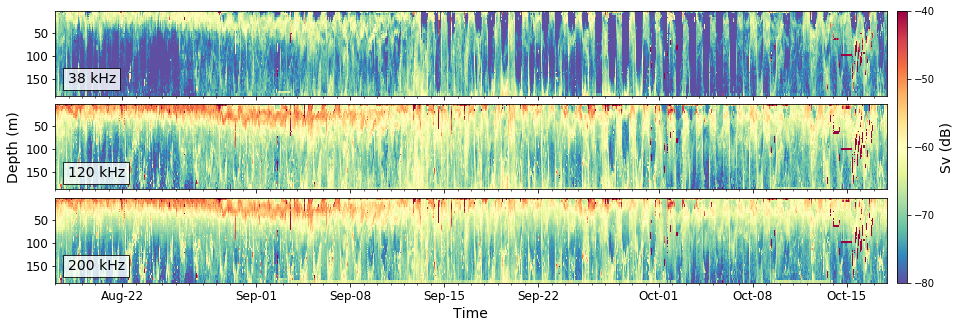

In [8]:
fig = plot_3_echograms(MVBS)
fig.savefig(os.path.join(fig_save_path,'MVBS.png'), 
            dpi=150, bbox_inches = 'tight', pad_inches = 0)

When assembling the DataArrat, note that we inverted the second dimension (depth) of the loaded data. This is because the sonar was upward-looking from an underwater platform and the echo time series was recorded from the source location, so the depth dimension was inverted. We only plot the first 37 depth bins because the last 3 bins contains very strong scattering from the sea surface that can dominate the decomposition. The surface scattering also include signatures from the tidal cycles that have a different periodicity than the daylight cycles on which our decomposition is structured.

### MVBS cleaned using PCP

Seeing the many noisy echo patches in the original calibrated MVBS data, we employed Principal Component Pursuit (PCP) to separate the noisy component from the low-rank component before applying tensor decomposition. PCP takes some time to run, so here we will proceed by loading the low-rank component from PCP that has been calculated elsewhere.

In [9]:
# Load PCP-cleaned MVBS data
MVBS_pcp_path = '../sample_data'
MVBS_pcp_fname = '20150817-20151017_MVBS_PCPcleaned.h5'
f_pcp = h5py.File(os.path.join(MVBS_pcp_path,MVBS_pcp_fname),'r')

# Load only low-rank data
L = np.array(f_pcp['L'])
L_sep = np.array(f_pcp['L_sep'])
depth_bin_size = np.array(f_pcp['depth_bin_size'])
ping_per_day_mvbs = np.array(f_pcp['ping_per_day_mvbs'])
ping_time = np.array(f_pcp['ping_time'])
f_pcp.close()

The low-rank data is organized with dimension `frequency` x `day of observation` x `depth` x `chunk of pings within day`.

In [10]:
L_sep.shape

(3, 62, 37, 144)

In [11]:
echoes_low_rank = []
for f in range(3):
    echoes_low_rank.append(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1)[::-1,:])

The same as before, we construct an xarray DataArray to make plotting easier:

In [12]:
frequency = np.array([38000,120000,200000])
p_time = pd.to_datetime(mdates.num2date(ping_time)).tz_convert(None)
depth = (np.arange(37)+1)*depth_bin_size
MVBS_pcp = xr.DataArray(np.array(echoes_low_rank), 
                        coords=[('frequency', frequency), 
                                ('depth', depth), 
                                ('ping_time', p_time)])

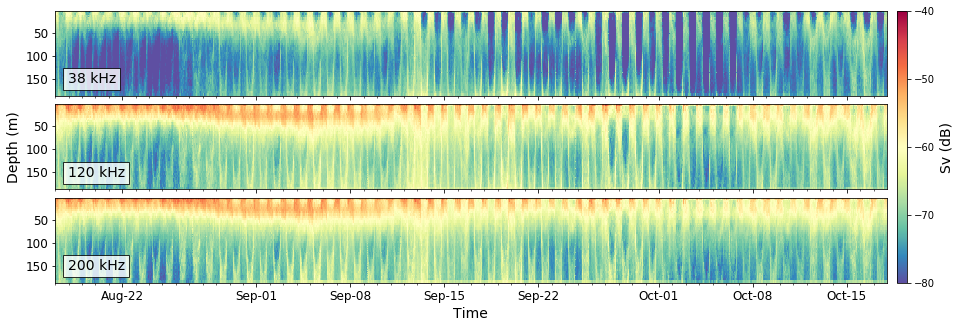

In [13]:
fig = plot_3_echograms(MVBS_pcp)
fig.savefig(os.path.join(fig_save_path,'MVBS_pcp.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)

### Data decimation

After some trial-and-error, we found out that tensor decomposition takes quite a bit of memory and that we can more efficiently run the decomposition by decimating the low-rank data by averaging 6 tiles of MVBS data, which effectively reduce the data to 1 observation per hour for each depth bin.

In [14]:
# Average across time of day columns
tod_num = 6
L_sep_reduce = np.empty(np.hstack((np.array(L_sep.shape[:3]),int(L_sep.shape[-1]/tod_num))))
for i in np.arange(int(L_sep.shape[-1]/tod_num)):
    L_sep_reduce[:,:,:,i] = np.mean(L_sep[:,:,:,i*tod_num+np.arange(tod_num)],axis=3)

In [15]:
L_sep_reduce.shape

(3, 62, 37, 24)

Similar to before, let's construct a DataArray for the decimated data:

In [16]:
echoes_low_rank_reduce = []
for f in range(3):
    echoes_low_rank_reduce.append(tl.unfold(tl.tensor(L_sep_reduce[f,:,:,:].squeeze()),mode=1)[::-1,:])
    
frequency = np.array([38000,120000,200000])
p_time_reduce = pd.to_datetime(mdates.num2date(ping_time[::tod_num])).tz_convert(None)
depth = (np.arange(37)+1)*depth_bin_size
MVBS_pcp_reduce = xr.DataArray(np.array(echoes_low_rank_reduce), 
                               coords=[('frequency', frequency), 
                                       ('depth', depth), 
                                       ('ping_time', p_time_reduce)])

On the grand scale the decimated data look very similar to without averaging over the pings:

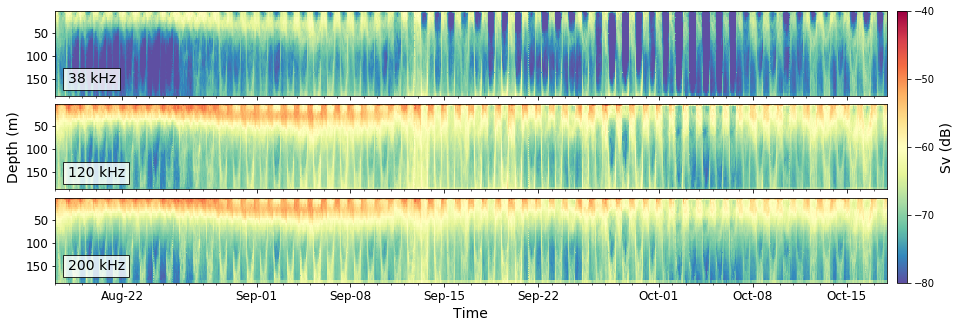

In [17]:
fig = plot_3_echograms(MVBS_pcp_reduce)
fig.savefig(os.path.join(fig_save_path,'MVBS_pcp_reduce.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)

But obviously the effects of decimation are much more prominent when you look at only a smaller number of days:

First we look at the pcp-cleaned MVBS data for the first 10 days:

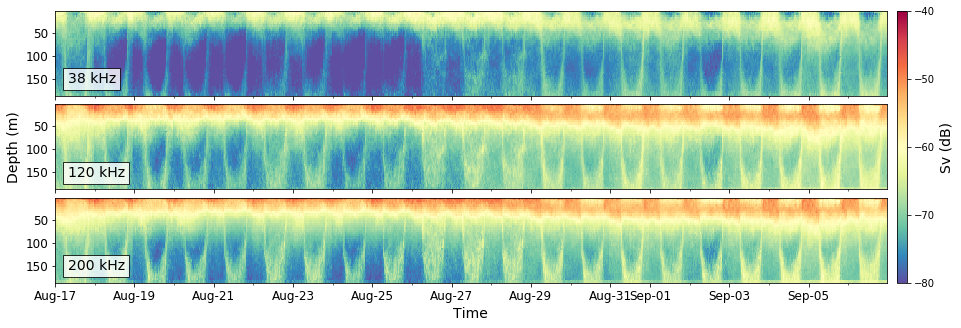

In [18]:
fig = plot_3_echograms(MVBS_pcp.sel(ping_time=slice('2015-08-16','2015-09-06')))

And when we compare it with the decimated data:

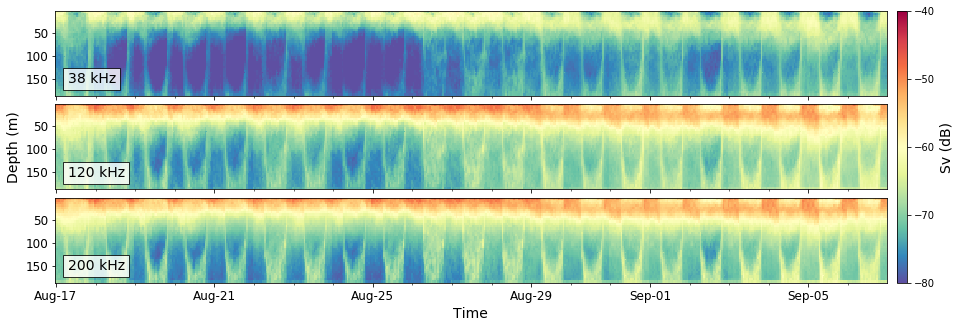

In [19]:
fig = plot_3_echograms(MVBS_pcp_reduce.sel(ping_time=slice('2015-08-16','2015-09-06')))

The basic features of the echograms are preserved in the decimated data, but the effects of quantization is also clearly visible.

## Restructuring data for tensor decomposition

Before performing tensor decomposition we need to reshape the low-rank data matrix into a tensor with all pixels within the daily echograms concatenated into a tall vector. 

This is because for decomposition, we actually don't want to decompose along each of the `frequency`, `day of observation`, `depth`, `chunk of pings within day` dimensions. Doing so will force decomposition along `depth` and `chunk of pings within day` separately, when in reality an organism group's movement in the water column (along `depth`) is coupled with the time of day (along `chunk of pings within day`).

Another way to think about this is that, for the Kruskal form of decomposition, it is not possible for a single component to capture the diel vertical migration (DVM), since the DVM pattern cannot be produced by an outer product of two vectors. It therefore makes more sense to go back to treate daily echogramss as images as it was done for NMF decomposition. The difference is that here we can arrange data from different frequencies along one specific dimension instead of concatenating them together.

### Reshaping the data matrix

We first inspect the dimension of the reduced low-rank data matrix:

In [20]:
L_sep_reduce.shape

(3, 62, 37, 24)

We then reshape this matrix to one that collapse all pixels within a daily echogram into a long vector:

In [21]:
L_sep_reduce_reshape = L_sep_reduce.reshape((3,62,37*24))

Let's plot the reshaped matrix out to check if it makes sense:

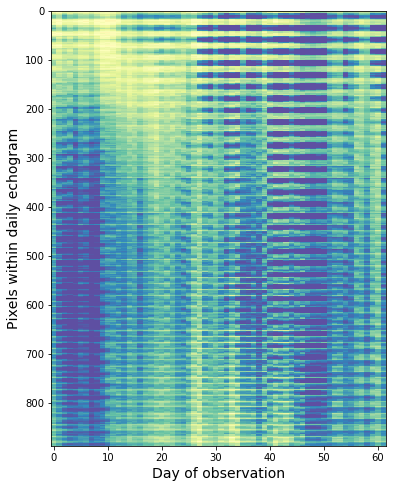

In [22]:
# Plot the first frequency of the reshaped reduced low-rank data matrix
fig = plt.figure(figsize=(6,8))
plt.imshow(tl.unfold(tl.tensor(L_sep_reduce_reshape[0,:,:]),mode=1)[::-1,:],
           vmin=-80, vmax=-40,
           aspect='auto',cmap='Spectral_r')
plt.xlabel('Day of observation',fontsize=14)
plt.ylabel('Pixels within daily echogram',fontsize=14)
plt.show()

This picture makes sense: The horizontal stripes within each column correspond with the number of depth bins for each ping. As organism vertical movements across consecutive days are typically smoothly-varying, the color changes smoothly along the horizontal dimension (`Day of observation`).

## Kruskal tensor decomposition

Now let's try to decompose the reshaped and reduced low-rank matrix using the Kruskal form of tensor decomposition. The decomposition will be along three dimensions: `frequency`, `day of observation` and `pixels within daily echogram`.

In [23]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import parafac
from tensorly.tenalg import kronecker, khatri_rao

In [24]:
sonar_tensor = tl.tensor(L_sep_reduce_reshape)

### Rank=3

We set rank=3 because we are limited by the number of frequencies we have in the data set. Note that in order to run the non-negative version of Kruskal decomposition we need to make all observations positive by substracting the minimum value.

In [25]:
kruskal_rank = 3

In [26]:
regular_3_rand = parafac(sonar_tensor-sonar_tensor.min(),  # regular kruskal
                       rank = 3,
                       n_iter_max=50000, 
                       verbose=1, 
                       tol=1e-10,
                       init='svd',
                       normalize_factors=True)

reconstruction error=0.06980115331418808
reconstruction error=0.0621605914631619, variation=0.007640561851026184.
reconstruction error=0.058166793428016624, variation=0.003993798035145275.
reconstruction error=0.056471945607341104, variation=0.00169484782067552.
reconstruction error=0.05561299950801092, variation=0.0008589460993301823.
reconstruction error=0.05511315601075868, variation=0.0004998434972522392.
reconstruction error=0.054798764150708945, variation=0.00031439186004973696.
reconstruction error=0.05458973841452421, variation=0.0002090257361847328.
reconstruction error=0.054444366855686266, variation=0.00014537155883794645.
reconstruction error=0.05433936568476806, variation=0.0001050011709182036.
reconstruction error=0.05426103144375074, variation=7.83342410173235e-05.
reconstruction error=0.05420093371409086, variation=6.00977296598762e-05.
reconstruction error=0.054153687464734764, variation=4.724624935609906e-05.
reconstruction error=0.05411574056078654, variation=3.79469

reconstruction error=0.053572566588938296, variation=4.0828702374332004e-06.
reconstruction error=0.053568491118571676, variation=4.075470366619871e-06.
reconstruction error=0.053564424138203, variation=4.066980368679085e-06.
reconstruction error=0.05356036673404224, variation=4.057404160755229e-06.
reconstruction error=0.05355631998670636, variation=4.0467473358812844e-06.
reconstruction error=0.05355228496999896, variation=4.035016707398809e-06.
reconstruction error=0.05354826274941347, variation=4.022220585493674e-06.
reconstruction error=0.053544254380915736, variation=4.008368497732118e-06.
reconstruction error=0.053540260909477305, variation=3.993471438430707e-06.
reconstruction error=0.05353628336777509, variation=3.977541702213094e-06.
reconstruction error=0.05353232277501017, variation=3.96059276492472e-06.
reconstruction error=0.05352838013566496, variation=3.942639345208554e-06.
reconstruction error=0.0535244564383681, variation=3.923697296862039e-06.
reconstruction error=0.

reconstruction error=0.053296583628103564, variation=9.289238039333902e-07.
reconstruction error=0.05329567356765468, variation=9.100604488818109e-07.
reconstruction error=0.053294782017195515, variation=8.91550459167223e-07.
reconstruction error=0.05329390862797623, variation=8.733892192872017e-07.
reconstruction error=0.05329305305569825, variation=8.555722779760022e-07.
reconstruction error=0.053292214960658946, variation=8.380950393058195e-07.
reconstruction error=0.05329139400790072, variation=8.209527582250797e-07.
reconstruction error=0.05329058986709663, variation=8.041408040906917e-07.
reconstruction error=0.05328980221263135, variation=7.876544652826722e-07.
reconstruction error=0.05328903072375918, variation=7.714888721685464e-07.
reconstruction error=0.05328827508444199, variation=7.556393171875841e-07.
reconstruction error=0.05328753498345711, variation=7.40100984879255e-07.
reconstruction error=0.05328681011431693, variation=7.248691401839924e-07.
reconstruction error=0.0

reconstruction error=0.053255994181146155, variation=8.149117753514235e-08.
reconstruction error=0.05325591426285385, variation=7.991829230336034e-08.
reconstruction error=0.05325583588553805, variation=7.837731580417895e-08.
reconstruction error=0.053255759017878344, variation=7.686765970266185e-08.
reconstruction error=0.053255683629315514, variation=7.538856282990336e-08.
reconstruction error=0.053255609689840146, variation=7.393947536876722e-08.
reconstruction error=0.05325553717018124, variation=7.251965890298084e-08.
reconstruction error=0.05325546604157902, variation=7.112860222341366e-08.
reconstruction error=0.053255396275993946, variation=6.976558507287844e-08.
reconstruction error=0.053255327845897704, variation=6.843009624224461e-08.
reconstruction error=0.05325526072440045, variation=6.712149725612848e-08.
reconstruction error=0.05325519488513039, variation=6.58392700567112e-08.
reconstruction error=0.05325513030226328, variation=6.458286710975258e-08.
reconstruction error

reconstruction error=0.05325219925525056, variation=9.630686755024431e-09.
reconstruction error=0.05325218979105597, variation=9.464194587749386e-09.
reconstruction error=0.0532521804904235, variation=9.300632472508674e-09.
reconstruction error=0.05325217135035939, variation=9.140064108348334e-09.
reconstruction error=0.053252162367963145, variation=8.98239624347319e-09.
reconstruction error=0.05325215354042515, variation=8.827537992250889e-09.
reconstruction error=0.05325214486492444, variation=8.675500713650752e-09.
reconstruction error=0.05325213633875597, variation=8.526168465694539e-09.
reconstruction error=0.05325212795923517, variation=8.379520806400809e-09.
reconstruction error=0.05325211972367288, variation=8.235562287683962e-09.
reconstruction error=0.05325211162957094, variation=8.094101937305975e-09.
reconstruction error=0.05325210367434705, variation=7.955223889355434e-09.
reconstruction error=0.053252095855530285, variation=7.818816767646286e-09.
reconstruction error=0.05

reconstruction error=0.053251713072194666, variation=1.3057847858544136e-09.
reconstruction error=0.05325171178753037, variation=1.2846642985508971e-09.
reconstruction error=0.053251710523552355, variation=1.2639780125334177e-09.
reconstruction error=0.053251709280003785, variation=1.2435485696737913e-09.
reconstruction error=0.05325170805648228, variation=1.2235215063327587e-09.
reconstruction error=0.053251706852719606, variation=1.2037626728744755e-09.
reconstruction error=0.05325170566837477, variation=1.184344837479312e-09.
reconstruction error=0.05325170450307043, variation=1.165304339134643e-09.
reconstruction error=0.05325170335655653, variation=1.146513897709589e-09.
reconstruction error=0.053251702228478456, variation=1.1280780753963882e-09.
reconstruction error=0.0532517011185975, variation=1.1098809579723756e-09.
reconstruction error=0.05325170002652724, variation=1.0920702606109778e-09.
reconstruction error=0.0532516989520267, variation=1.0745005371570748e-09.
reconstructi

reconstruction error=0.05325164468526681, variation=1.9770472758917634e-10.
reconstruction error=0.0532516444906832, variation=1.9458360617230497e-10.
reconstruction error=0.05325164429912982, variation=1.9155338426557478e-10.
reconstruction error=0.05325164411057254, variation=1.885572809001701e-10.
reconstruction error=0.05325164392496818, variation=1.8560435827152943e-10.
reconstruction error=0.053251643742278094, variation=1.8269008528193353e-10.
reconstruction error=0.053251643562443184, variation=1.798349108517172e-10.
reconstruction error=0.053251643385404335, variation=1.7703884885866827e-10.
reconstruction error=0.05325164321114337, variation=1.7426096676764757e-10.
reconstruction error=0.053251643039598916, variation=1.7154445225431303e-10.
reconstruction error=0.053251642870770964, variation=1.688279516187663e-10.
reconstruction error=0.0532516427045663, variation=1.6620466114503074e-10.
reconstruction error=0.05325164254096905, variation=1.6359725379944123e-10.
reconstructi

In [27]:
nonneg_3_rand = parafac(sonar_tensor-sonar_tensor.min(),  # non-negative kruskal
                       rank = 3,
                       n_iter_max=50000, 
                       verbose=1, 
                       tol=1e-10,
                       init='svd',
                       normalize_factors=True,
                       non_negative=True)

reconstruction error=0.22191103990347116
reconstruction error=0.20265756598684792, variation=0.019253473916623243.
reconstruction error=0.1792881806246536, variation=0.023369385362194323.
reconstruction error=0.1623103072746698, variation=0.016977873349983796.
reconstruction error=0.15025961697920875, variation=0.012050690295461047.
reconstruction error=0.14151901358004265, variation=0.008740603399166103.
reconstruction error=0.13500652854126216, variation=0.006512485038780491.
reconstruction error=0.13002659565712818, variation=0.004979932884133981.
reconstruction error=0.1261282243211565, variation=0.0038983713359716787.
reconstruction error=0.12301291217487813, variation=0.0031153121462783734.
reconstruction error=0.12047819622501185, variation=0.002534715949866276.
reconstruction error=0.11838328819444033, variation=0.002094908030571524.
reconstruction error=0.11662792410305119, variation=0.0017553640913891416.
reconstruction error=0.115139102513855, variation=0.0014888215891961931

reconstruction error=0.07280732636286852, variation=5.0005739960487516e-05.
reconstruction error=0.07275855319515415, variation=4.877316771437212e-05.
reconstruction error=0.07271095392486472, variation=4.759927028942512e-05.
reconstruction error=0.07266447253237572, variation=4.648139248900063e-05.
reconstruction error=0.0726190555354505, variation=4.54169969252155e-05.
reconstruction error=0.07257465187268491, variation=4.440366276559082e-05.
reconstruction error=0.07253121278888429, variation=4.3439083800625444e-05.
reconstruction error=0.07248869172284138, variation=4.252106604291095e-05.
reconstruction error=0.07244704419764281, variation=4.1647525198570956e-05.
reconstruction error=0.07240622771425971, variation=4.0816483383096513e-05.
reconstruction error=0.07236620164818326, variation=4.002606607644843e-05.
reconstruction error=0.07232692714977317, variation=3.927449841009678e-05.
reconstruction error=0.07228836704818929, variation=3.856010158387324e-05.
reconstruction error=0.

reconstruction error=0.0667230905744341, variation=4.609493492653549e-05.
reconstruction error=0.06667740653998988, variation=4.568403444421554e-05.
reconstruction error=0.06663214821809366, variation=4.525832189622436e-05.
reconstruction error=0.06658732989525054, variation=4.481832284311538e-05.
reconstruction error=0.06654296530968196, variation=4.43645855685848e-05.
reconstruction error=0.06649906763036606, variation=4.3897679315896276e-05.
reconstruction error=0.06645564943775562, variation=4.3418192610444883e-05.
reconstruction error=0.06641272270619474, variation=4.2926731560880005e-05.
reconstruction error=0.066370298788323, variation=4.2423917871736716e-05.
reconstruction error=0.06632838840137423, variation=4.1910386948770806e-05.
reconstruction error=0.0662870016152148, variation=4.1386786159433586e-05.
reconstruction error=0.06624614784259546, variation=4.085377261933698e-05.
reconstruction error=0.06620583583119603, variation=4.031201139942375e-05.
reconstruction error=0.0

reconstruction error=0.06435635238426607, variation=1.5771128027974868e-06.
reconstruction error=0.06435479563876288, variation=1.5567455031867405e-06.
reconstruction error=0.06435325877629607, variation=1.536862466816613e-06.
reconstruction error=0.06435174132651404, variation=1.5174497820236166e-06.
reconstruction error=0.06435024283264712, variation=1.4984938669221348e-06.
reconstruction error=0.06434876285111904, variation=1.4799815280797102e-06.
reconstruction error=0.06434730095099118, variation=1.461900127855409e-06.
reconstruction error=0.06434585671386356, variation=1.4442371276263133e-06.
reconstruction error=0.06434442973323035, variation=1.426980633212338e-06.
reconstruction error=0.06434301961428467, variation=1.4101189456799945e-06.
reconstruction error=0.06434162597356914, variation=1.3936407155246133e-06.
reconstruction error=0.06434024843855297, variation=1.3775350161671085e-06.
reconstruction error=0.06433888664739316, variation=1.361791159809611e-06.
reconstruction e

reconstruction error=0.06422344165773765, variation=5.397257692024704e-07.
reconstruction error=0.06422290375855108, variation=5.378991865673255e-07.
reconstruction error=0.06422236766157223, variation=5.360969788509307e-07.
reconstruction error=0.06422183334287382, variation=5.343186984113624e-07.
reconstruction error=0.0642213007789197, variation=5.32563954117049e-07.
reconstruction error=0.06422076994667605, variation=5.308322436475832e-07.
reconstruction error=0.06422024082345877, variation=5.291232172827121e-07.
reconstruction error=0.06421971338711821, variation=5.274363405610716e-07.
reconstruction error=0.06421918761586388, variation=5.257712543255133e-07.
reconstruction error=0.0642186634883814, variation=5.241274824846487e-07.
reconstruction error=0.06421814098377583, variation=5.225046055684635e-07.
reconstruction error=0.06421762008160772, variation=5.209021681079617e-07.
reconstruction error=0.06421710076187599, variation=5.193197317315823e-07.
reconstruction error=0.06421

reconstruction error=0.06415275231923759, variation=3.459009060291507e-07.
reconstruction error=0.0641524074211538, variation=3.448980837872373e-07.
reconstruction error=0.06415206351834359, variation=3.439028102153463e-07.
reconstruction error=0.06415172060319765, variation=3.4291514593165484e-07.
reconstruction error=0.06415137866792912, variation=3.419352685302135e-07.
reconstruction error=0.06415103770457545, variation=3.4096335367606034e-07.
reconstruction error=0.06415069770508328, variation=3.39999492171561e-07.
reconstruction error=0.06415035866123295, variation=3.3904385032812456e-07.
reconstruction error=0.06415002056467255, variation=3.3809656040106884e-07.
reconstruction error=0.064149683406948, variation=3.3715772454478987e-07.
reconstruction error=0.0641493471794654, variation=3.362274826057554e-07.
reconstruction error=0.06414901187348906, variation=3.353059763316901e-07.
reconstruction error=0.06414867748022651, variation=3.343932625521351e-07.
reconstruction error=0.06

reconstruction error=0.06410511123016417, variation=2.8235938284715267e-07.
reconstruction error=0.06410482901233731, variation=2.82217826858e-07.
reconstruction error=0.06410454693718437, variation=2.820751529436505e-07.
reconstruction error=0.06410426500587801, variation=2.819313063562312e-07.
reconstruction error=0.06410398321962114, variation=2.817862568699203e-07.
reconstruction error=0.0641037015795846, variation=2.8164003654240766e-07.
reconstruction error=0.06410342008695623, variation=2.8149262837340316e-07.
reconstruction error=0.06410313874286912, variation=2.8134408711077974e-07.
reconstruction error=0.06410285754855838, variation=2.811943107389192e-07.
reconstruction error=0.0641025765051949, variation=2.8104336348422354e-07.
reconstruction error=0.06410229561393639, variation=2.808912585028356e-07.
reconstruction error=0.06410201487599534, variation=2.8073794104688243e-07.
reconstruction error=0.06410173429253141, variation=2.805834639352245e-07.
reconstruction error=0.06

reconstruction error=0.06406189280466854, variation=2.545844035167777e-07.
reconstruction error=0.06406163838736645, variation=2.544173020868623e-07.
reconstruction error=0.06406138413745874, variation=2.542499077107241e-07.
reconstruction error=0.06406113005537074, variation=2.5408208799426735e-07.
reconstruction error=0.06406087614146531, variation=2.539139054291706e-07.
reconstruction error=0.06406062239624148, variation=2.5374522383270204e-07.
reconstruction error=0.064060368820168, variation=2.535760734861947e-07.
reconstruction error=0.06406011541375706, variation=2.5340641093829497e-07.
reconstruction error=0.06405986217760404, variation=2.532361530194205e-07.
reconstruction error=0.06405960911224955, variation=2.5306535449132195e-07.
reconstruction error=0.06405935621836455, variation=2.528938849999385e-07.
reconstruction error=0.06405910349663892, variation=2.527217256298453e-07.
reconstruction error=0.06405885094774744, variation=2.5254889148007553e-07.
reconstruction error=0

reconstruction error=0.06402689439534491, variation=2.1976175232363282e-07.
reconstruction error=0.0640266748129166, variation=2.1958242830966146e-07.
reconstruction error=0.06402645540611224, variation=2.1940680436371984e-07.
reconstruction error=0.06402623617126947, variation=2.192348427659807e-07.
reconstruction error=0.06402601710466543, variation=2.1906660403747669e-07.
reconstruction error=0.06402579820261688, variation=2.1890204855712359e-07.
reconstruction error=0.0640255794613876, variation=2.1874122928255968e-07.
reconstruction error=0.0640253608772432, variation=2.1858414439579477e-07.
reconstruction error=0.06402514244648519, variation=2.1843075800886957e-07.
reconstruction error=0.06402492416537528, variation=2.1828110990940175e-07.
reconstruction error=0.06402470603019973, variation=2.1813517554758466e-07.
reconstruction error=0.06402448803723151, variation=2.1799296821833902e-07.
reconstruction error=0.06402427018279462, variation=2.1785443689303907e-07.
reconstruction e

reconstruction error=0.06399155033683614, variation=2.0004733368439442e-07.
reconstruction error=0.063991350677786, variation=1.9965905014018848e-07.
reconstruction error=0.06399115141183365, variation=1.9926595234975863e-07.
reconstruction error=0.06399095254374046, variation=1.9886809318747645e-07.
reconstruction error=0.0639907540782054, variation=1.9846553506175368e-07.
reconstruction error=0.06399055601984237, variation=1.9805836302955182e-07.
reconstruction error=0.06399035837319153, variation=1.9764665083743527e-07.
reconstruction error=0.06399016114270986, variation=1.9723048166886414e-07.
reconstruction error=0.06398996433278063, variation=1.968099292287695e-07.
reconstruction error=0.06398976794768875, variation=1.963850918829113e-07.
reconstruction error=0.06398957199160947, variation=1.9595607927969105e-07.
reconstruction error=0.06398937646870673, variation=1.9552290274338358e-07.
reconstruction error=0.06398918138296665, variation=1.9508574007620627e-07.
reconstruction er

reconstruction error=0.06396637963308908, variation=1.3377054854102344e-07.
reconstruction error=0.06396624615270481, variation=1.3348038427341002e-07.
reconstruction error=0.06396611296043896, variation=1.3319226585539745e-07.
reconstruction error=0.06396598005427032, variation=1.3290616864003457e-07.
reconstruction error=0.06396584743222491, variation=1.3262204540120948e-07.
reconstruction error=0.0639657150923496, variation=1.3233987530836266e-07.
reconstruction error=0.06396558303269313, variation=1.32059656474115e-07.
reconstruction error=0.06396545125133254, variation=1.3178136058777934e-07.
reconstruction error=0.06396531974637333, variation=1.3150495921376848e-07.
reconstruction error=0.06396518851592092, variation=1.3123045240759357e-07.
reconstruction error=0.06396505755813559, variation=1.3095778533811497e-07.
reconstruction error=0.06396492687114548, variation=1.306869901046559e-07.
reconstruction error=0.06396479645314301, variation=1.3041800246693658e-07.
reconstruction e

reconstruction error=0.06394709732476979, variation=1.039763043580999e-07.
reconstruction error=0.06394699343480746, variation=1.0388996232735259e-07.
reconstruction error=0.06394688962988705, variation=1.0380492040940048e-07.
reconstruction error=0.06394678590872739, variation=1.0372115966106321e-07.
reconstruction error=0.06394668227003408, variation=1.0363869330787256e-07.
reconstruction error=0.06394657871248237, variation=1.0355755171442826e-07.
reconstruction error=0.06394647523474754, variation=1.0347773482521916e-07.
reconstruction error=0.06394637183553135, variation=1.0339921618918169e-07.
reconstruction error=0.06394626851342577, variation=1.0332210557961741e-07.
reconstruction error=0.06394616526717228, variation=1.0324625349111827e-07.
reconstruction error=0.06394606209535716, variation=1.0317181511898532e-07.
reconstruction error=0.0639459589966102, variation=1.0309874697023158e-07.
reconstruction error=0.06394585596954788, variation=1.0302706231202219e-07.
reconstruction

reconstruction error=0.06393140153334258, variation=1.1195553742404663e-07.
reconstruction error=0.06393128935550126, variation=1.1217784132155906e-07.
reconstruction error=0.06393117695361286, variation=1.1240188839412024e-07.
reconstruction error=0.0639310643259929, variation=1.1262761996644333e-07.
reconstruction error=0.06393095147099281, variation=1.128550000811801e-07.
reconstruction error=0.06393083838695272, variation=1.1308404009036099e-07.
reconstruction error=0.0639307250723812, variation=1.1331457151764202e-07.
reconstruction error=0.06393061152575656, variation=1.1354662464435616e-07.
reconstruction error=0.06393049774560629, variation=1.1378015027374566e-07.
reconstruction error=0.0639303837305658, variation=1.1401504049213251e-07.
reconstruction error=0.06393026947929514, variation=1.1425127065256557e-07.
reconstruction error=0.0639301549904903, variation=1.1448880483933e-07.
reconstruction error=0.06393004026296467, variation=1.1472752563246313e-07.
reconstruction error

reconstruction error=0.0639107086670284, variation=1.1638668914737416e-07.
reconstruction error=0.06391059263046941, variation=1.1603655898639875e-07.
reconstruction error=0.06391047694608057, variation=1.1568438884612675e-07.
reconstruction error=0.06391036161579197, variation=1.1533028859700423e-07.
reconstruction error=0.0639102466414144, variation=1.1497437757412854e-07.
reconstruction error=0.06391013202470185, variation=1.1461671255152961e-07.
reconstruction error=0.06391001776723212, variation=1.1425746972160145e-07.
reconstruction error=0.06390990387059066, variation=1.1389664146543854e-07.
reconstruction error=0.06390979033614694, variation=1.1353444372141919e-07.
reconstruction error=0.06390967716527045, variation=1.1317087648954338e-07.
reconstruction error=0.06390956435914882, variation=1.1280612162434256e-07.
reconstruction error=0.06390945191895082, variation=1.1244019799960814e-07.
reconstruction error=0.06390933984572959, variation=1.1207322123119035e-07.
reconstruction

reconstruction error=0.06389673985530021, variation=7.292224263322211e-08.
reconstruction error=0.06389666708387984, variation=7.277142037576123e-08.
reconstruction error=0.06389659446204513, variation=7.262183471246075e-08.
reconstruction error=0.0638965219885102, variation=7.247353492334518e-08.
reconstruction error=0.06389644966209529, variation=7.232641491272673e-08.
reconstruction error=0.06389637748153346, variation=7.218056183311283e-08.
reconstruction error=0.0638963054456847, variation=7.20358487582562e-08.
reconstruction error=0.06389623355334077, variation=7.189234392523947e-08.
reconstruction error=0.0638961618033617, variation=7.174997906922442e-08.
reconstruction error=0.06389609019456385, variation=7.160879784973151e-08.
reconstruction error=0.06389601872588486, variation=7.146867898877307e-08.
reconstruction error=0.06389594739617713, variation=7.132970773759961e-08.
reconstruction error=0.06389587620436693, variation=7.119181019699106e-08.
reconstruction error=0.063895

reconstruction error=0.06388638296452623, variation=5.693626324576595e-08.
reconstruction error=0.06388632610153983, variation=5.6862986402839155e-08.
reconstruction error=0.06388626931166184, variation=5.6789877980745196e-08.
reconstruction error=0.06388621259475036, variation=5.671691148678715e-08.
reconstruction error=0.0638861559506123, variation=5.664413806061308e-08.
reconstruction error=0.06388609937915689, variation=5.6571455409049065e-08.
reconstruction error=0.06388604288015316, variation=5.6499003725507535e-08.
reconstruction error=0.06388598645347815, variation=5.642667501304377e-08.
reconstruction error=0.06388593009894447, variation=5.6354533678470986e-08.
reconstruction error=0.06388587381645755, variation=5.628248692102211e-08.
reconstruction error=0.06388581760579021, variation=5.621066734295965e-08.
reconstruction error=0.06388576146682136, variation=5.6138968848595816e-08.
reconstruction error=0.0638857053994034, variation=5.6067417958383103e-08.
reconstruction error

reconstruction error=0.06387965054541192, variation=4.866906617995159e-08.
reconstruction error=0.06387960193324828, variation=4.861216364171472e-08.
reconstruction error=0.06387955337786602, variation=4.8555382256565416e-08.
reconstruction error=0.06387950487916864, variation=4.8498697377552524e-08.
reconstruction error=0.06387945643706909, variation=4.844209955390255e-08.
reconstruction error=0.06387940805140262, variation=4.8385666473471645e-08.
reconstruction error=0.06387935972214095, variation=4.83292616620945e-08.
reconstruction error=0.06387931144912123, variation=4.827301972043507e-08.
reconstruction error=0.06387926323223936, variation=4.821688187606199e-08.
reconstruction error=0.06387921507142724, variation=4.816081211611589e-08.
reconstruction error=0.06387916696655616, variation=4.81048710865295e-08.
reconstruction error=0.06387911891753524, variation=4.8049020914819884e-08.
reconstruction error=0.06387907092423009, variation=4.799330514948519e-08.
reconstruction error=0.

reconstruction error=0.06387252763830847, variation=4.083318715097928e-08.
reconstruction error=0.06387248684618, variation=4.0792128480626744e-08.
reconstruction error=0.06387244609501933, variation=4.075116066815099e-08.
reconstruction error=0.06387240538469952, variation=4.07103198096781e-08.
reconstruction error=0.06387236471514109, variation=4.066955842929598e-08.
reconstruction error=0.06387232408621712, variation=4.062892396128337e-08.
reconstruction error=0.06387228349783483, variation=4.058838229403783e-08.
reconstruction error=0.06387224294989004, variation=4.054794479346757e-08.
reconstruction error=0.06387220244226914, variation=4.050762089646831e-08.
reconstruction error=0.06387216197486605, variation=4.046740309515684e-08.
reconstruction error=0.0638721215475804, variation=4.042728564412901e-08.
reconstruction error=0.06387208116030994, variation=4.038727045851953e-08.
reconstruction error=0.06387204081292966, variation=4.034738028402263e-08.
reconstruction error=0.063872

reconstruction error=0.06386683467019189, variation=3.617489172103028e-08.
reconstruction error=0.06386679851306043, variation=3.6157131455549774e-08.
reconstruction error=0.0638667623734182, variation=3.6139642223265156e-08.
reconstruction error=0.06386672625099607, variation=3.612242213679728e-08.
reconstruction error=0.0638666901455458, variation=3.610545026844214e-08.
reconstruction error=0.06386665405682858, variation=3.608871722293738e-08.
reconstruction error=0.06386661798458097, variation=3.6072247605600793e-08.
reconstruction error=0.06386658192849028, variation=3.605609069645688e-08.
reconstruction error=0.06386654588832717, variation=3.60401631038787e-08.
reconstruction error=0.06386650986382822, variation=3.602449895334647e-08.
reconstruction error=0.06386647385473188, variation=3.6009096343603275e-08.
reconstruction error=0.06386643786071405, variation=3.599401782183875e-08.
reconstruction error=0.06386640188156441, variation=3.5979149645704034e-08.
reconstruction error=0.

reconstruction error=0.06386087897534336, variation=3.854638568057123e-08.
reconstruction error=0.06386084037039905, variation=3.8604944310738354e-08.
reconstruction error=0.06386080170635387, variation=3.866404517383071e-08.
reconstruction error=0.06386076298254428, variation=3.8723809589469305e-08.
reconstruction error=0.06386072419842612, variation=3.8784118167045634e-08.
reconstruction error=0.06386068535336993, variation=3.8845056185565774e-08.
reconstruction error=0.0638606464467842, variation=3.8906585730913434e-08.
reconstruction error=0.0638606074781229, variation=3.8968661297822393e-08.
reconstruction error=0.06386056844675278, variation=3.903137012206681e-08.
reconstruction error=0.06386052935211071, variation=3.9094642065307106e-08.
reconstruction error=0.06386049019361659, variation=3.915849412783334e-08.
reconstruction error=0.06386045097069587, variation=3.9222920716897036e-08.
reconstruction error=0.06386041168275515, variation=3.928794072016739e-08.
reconstruction erro

reconstruction error=0.06385437018778543, variation=4.833259979741822e-08.
reconstruction error=0.06385432185108453, variation=4.833670090576003e-08.
reconstruction error=0.06385427351233182, variation=4.833875270893184e-08.
reconstruction error=0.0638542251735899, variation=4.833874191201293e-08.
reconstruction error=0.06385417683696124, variation=4.833662867187449e-08.
reconstruction error=0.06385412850454437, variation=4.8332416860419336e-08.
reconstruction error=0.06385408017846644, variation=4.8326077931037936e-08.
reconstruction error=0.06385403186087345, variation=4.831759299606109e-08.
reconstruction error=0.06385398355394367, variation=4.830692977575435e-08.
reconstruction error=0.06385393525980798, variation=4.829413569051866e-08.
reconstruction error=0.06385388698069776, variation=4.8279110223536925e-08.
reconstruction error=0.06385383871881213, variation=4.8261885626788015e-08.
reconstruction error=0.06385379047636731, variation=4.8242444816715135e-08.
reconstruction error=

reconstruction error=0.06384776089807696, variation=3.005342204265293e-08.
reconstruction error=0.06384773095235997, variation=2.994571698944348e-08.
reconstruction error=0.06384770111314997, variation=2.983921000565548e-08.
reconstruction error=0.06384767137925829, variation=2.9733891682148794e-08.
reconstruction error=0.06384764174944706, variation=2.962981122955899e-08.
reconstruction error=0.0638476122225864, variation=2.9526860650941344e-08.
reconstruction error=0.06384758279740996, variation=2.942517644821674e-08.
reconstruction error=0.06384755347280116, variation=2.9324608796788e-08.
reconstruction error=0.063847524247541, variation=2.922526015636251e-08.
reconstruction error=0.06384749512042191, variation=2.9127119091643117e-08.
reconstruction error=0.06384746609033867, variation=2.903008324006695e-08.
reconstruction error=0.06384743715606848, variation=2.8934270188130107e-08.
reconstruction error=0.06384740831647392, variation=2.883959455968199e-08.
reconstruction error=0.063

reconstruction error=0.06384390922697798, variation=2.3063678467050153e-08.
reconstruction error=0.06384388617254597, variation=2.3054432016222925e-08.
reconstruction error=0.06384386312697925, variation=2.304556671883784e-08.
reconstruction error=0.06384384008999916, variation=2.3036980087431935e-08.
reconstruction error=0.06384381706128525, variation=2.30287139080243e-08.
reconstruction error=0.06384379404050003, variation=2.3020785222538365e-08.
reconstruction error=0.0638437710273079, variation=2.3013192129717197e-08.
reconstruction error=0.06384374802142635, variation=2.3005881547022433e-08.
reconstruction error=0.06384372502246101, variation=2.2998965343301592e-08.
reconstruction error=0.06384370203015782, variation=2.299230318636436e-08.
reconstruction error=0.06384367904416219, variation=2.2985995634661194e-08.
reconstruction error=0.06384365606414234, variation=2.298001984535336e-08.
reconstruction error=0.0638436330897911, variation=2.2974351240878654e-08.
reconstruction erro

reconstruction error=0.06384017573510749, variation=2.6791421636751522e-08.
reconstruction error=0.063840148875298, variation=2.685980948768929e-08.
reconstruction error=0.06384012194644263, variation=2.6928855367813753e-08.
reconstruction error=0.06384009494789276, variation=2.6998549867984778e-08.
reconstruction error=0.06384006787898086, variation=2.7068911903627146e-08.
reconstruction error=0.06384004073908867, variation=2.7139892194716353e-08.
reconstruction error=0.06384001352754295, variation=2.7211545711169904e-08.
reconstruction error=0.06383998624375581, variation=2.7283787146226146e-08.
reconstruction error=0.06383995888702744, variation=2.7356728368732597e-08.
reconstruction error=0.06383993145674717, variation=2.7430280269413743e-08.
reconstruction error=0.0638399039522759, variation=2.7504471269979014e-08.
reconstruction error=0.06383987637301243, variation=2.7579263470189908e-08.
reconstruction error=0.0638398487182987, variation=2.7654713727343072e-08.
reconstruction er

reconstruction error=0.06383507662000625, variation=3.753492228142363e-08.
reconstruction error=0.06383503909905312, variation=3.752095312226089e-08.
reconstruction error=0.0638350015942215, variation=3.750483162923146e-08.
reconstruction error=0.0638349641076391, variation=3.7486582393775336e-08.
reconstruction error=0.06383492664148298, variation=3.7466156121990224e-08.
reconstruction error=0.06383488919792639, variation=3.744355658863441e-08.
reconstruction error=0.06383485177911032, variation=3.741881607344233e-08.
reconstruction error=0.06383481438718908, variation=3.7391921239859904e-08.
reconstruction error=0.06383477702431697, variation=3.736287210176492e-08.
reconstruction error=0.06383473969262934, variation=3.733168763009331e-08.
reconstruction error=0.06383470239429376, variation=3.7298335586744e-08.
reconstruction error=0.06383466513141524, variation=3.726287851890664e-08.
reconstruction error=0.06383462790613484, variation=3.7225280399844074e-08.
reconstruction error=0.06

reconstruction error=0.06383021179476456, variation=2.3902980220147363e-08.
reconstruction error=0.06383018793885377, variation=2.385591078846172e-08.
reconstruction error=0.06383016412870765, variation=2.3810146118630193e-08.
reconstruction error=0.06383014036314284, variation=2.3765564807765038e-08.
reconstruction error=0.06383011664084705, variation=2.3722295794392778e-08.
reconstruction error=0.06383009296062739, variation=2.3680219660149326e-08.
reconstruction error=0.06383006932129484, variation=2.3639332547009673e-08.
reconstruction error=0.06383004572157878, variation=2.3599716056366127e-08.
reconstruction error=0.06383002216024847, variation=2.3561330317334317e-08.
reconstruction error=0.06382999863612619, variation=2.3524122275131454e-08.
reconstruction error=0.06382997514800014, variation=2.3488126055237757e-08.
reconstruction error=0.063829951694649, variation=2.34533511361823e-08.
reconstruction error=0.06382992827487806, variation=2.3419770942001428e-08.
reconstruction er

reconstruction error=0.06382650215250577, variation=2.6753423809644516e-08.
reconstruction error=0.06382647535180189, variation=2.6800703878393506e-08.
reconstruction error=0.06382644850403596, variation=2.6847765927096034e-08.
reconstruction error=0.06382642160938247, variation=2.6894653490372455e-08.
reconstruction error=0.06382639466805941, variation=2.694132306135799e-08.
reconstruction error=0.063826367680264, variation=2.6987795401223202e-08.
reconstruction error=0.06382634064624085, variation=2.703402315895609e-08.
reconstruction error=0.06382631356624593, variation=2.7079994913137284e-08.
reconstruction error=0.06382628644050486, variation=2.7125741069999876e-08.
reconstruction error=0.06382625926929451, variation=2.7171210351117914e-08.
reconstruction error=0.06382623205286894, variation=2.7216425571574554e-08.
reconstruction error=0.06382620479150504, variation=2.7261363902408853e-08.
reconstruction error=0.06382617748550236, variation=2.730600268119332e-08.
reconstruction er

reconstruction error=0.063821958213231, variation=2.8709925076197962e-08.
reconstruction error=0.06382192953089613, variation=2.868233486830185e-08.
reconstruction error=0.06382190087673759, variation=2.8654158545915465e-08.
reconstruction error=0.06382187225138325, variation=2.86253543368975e-08.
reconstruction error=0.06382184365548942, variation=2.859589383341632e-08.
reconstruction error=0.06382181508962134, variation=2.8565868073759937e-08.
reconstruction error=0.06382178655446001, variation=2.8535161331055825e-08.
reconstruction error=0.06382175805063517, variation=2.850382484209657e-08.
reconstruction error=0.06382172957879556, variation=2.8471839608190663e-08.
reconstruction error=0.0638217011395766, variation=2.8439218965892188e-08.
reconstruction error=0.06382167273364601, variation=2.8405930579955552e-08.
reconstruction error=0.06382164436166769, variation=2.8371978322283553e-08.
reconstruction error=0.06382161602429608, variation=2.8337371615894114e-08.
reconstruction error

reconstruction error=0.06381834186520523, variation=1.8962334424887928e-08.
reconstruction error=0.06381832297310126, variation=1.8892103964551765e-08.
reconstruction error=0.06381830415074986, variation=1.8822351399716553e-08.
reconstruction error=0.06381828539762943, variation=1.8753120431536097e-08.
reconstruction error=0.06381826671330565, variation=1.8684323782602874e-08.
reconstruction error=0.06381824809725507, variation=1.8616050576070187e-08.
reconstruction error=0.06381822954899026, variation=1.854826481295646e-08.
reconstruction error=0.0638182110679972, variation=1.848099305534756e-08.
reconstruction error=0.06381819265383025, variation=1.8414166955138533e-08.
reconstruction error=0.06381817430593935, variation=1.834789090104927e-08.
reconstruction error=0.06381815602380482, variation=1.8282134528480043e-08.
reconstruction error=0.06381813780695442, variation=1.821685040315213e-08.
reconstruction error=0.06381811965486654, variation=1.8152087874478973e-08.
reconstruction er

reconstruction error=0.06381593386477057, variation=1.2910680455280321e-08.
reconstruction error=0.06381592097374517, variation=1.2891025399919265e-08.
reconstruction error=0.06381590810226671, variation=1.2871478452525231e-08.
reconstruction error=0.06381589525026124, variation=1.2852005473740213e-08.
reconstruction error=0.06381588241763392, variation=1.2832627321879286e-08.
reconstruction error=0.06381586960433734, variation=1.281329657654151e-08.
reconstruction error=0.06381585681025959, variation=1.2794077755562405e-08.
reconstruction error=0.06381584403531151, variation=1.277494807161439e-08.
reconstruction error=0.06381583127944193, variation=1.2755869582825596e-08.
reconstruction error=0.06381581854257116, variation=1.2736870766416608e-08.
reconstruction error=0.06381580582461008, variation=1.271796108703871e-08.
reconstruction error=0.06381579312549229, variation=1.2699117785119896e-08.
reconstruction error=0.06381578044512677, variation=1.2680365521489101e-08.
reconstruction 

reconstruction error=0.063814168027483, variation=1.0479545078934116e-08.
reconstruction error=0.06381415756167398, variation=1.0465809024973183e-08.
reconstruction error=0.06381414710954604, variation=1.0452127940929756e-08.
reconstruction error=0.06381413667111624, variation=1.0438429801085114e-08.
reconstruction error=0.0638141262463353, variation=1.0424780941264977e-08.
reconstruction error=0.063814115835188, variation=1.0411147291500278e-08.
reconstruction error=0.06381410543765731, variation=1.0397530697536794e-08.
reconstruction error=0.063814095053711, variation=1.0383946313918813e-08.
reconstruction error=0.06381408468335852, variation=1.0370352479527334e-08.
reconstruction error=0.06381407432654299, variation=1.035681553018808e-08.
reconstruction error=0.06381406398325494, variation=1.034328804550011e-08.
reconstruction error=0.06381405365348866, variation=1.0329766278460717e-08.
reconstruction error=0.06381404333721953, variation=1.0316269130616895e-08.
reconstruction error=

reconstruction error=0.06381269729867058, variation=8.583532842831865e-09.
reconstruction error=0.06381268872599694, variation=8.572673640405704e-09.
reconstruction error=0.06381268016416923, variation=8.561827705144687e-09.
reconstruction error=0.06381267161317417, variation=8.55099506480439e-09.
reconstruction error=0.06381266307298329, variation=8.540190873929099e-09.
reconstruction error=0.06381265454360044, variation=8.529382852784373e-09.
reconstruction error=0.06381264602499334, variation=8.5186070974963e-09.
reconstruction error=0.06381263751716579, variation=8.507827553572156e-09.
reconstruction error=0.06381262902007606, variation=8.497089726278162e-09.
reconstruction error=0.06381262053372985, variation=8.486346209091167e-09.
reconstruction error=0.0638126120581101, variation=8.475619747705387e-09.
reconstruction error=0.06381260359318645, variation=8.464923650919332e-09.
reconstruction error=0.06381259513893045, variation=8.454256003598282e-09.
reconstruction error=0.063812

reconstruction error=0.06381151010551467, variation=7.101546309340456e-09.
reconstruction error=0.06381150301266551, variation=7.09284915523245e-09.
reconstruction error=0.06381149592854954, variation=7.084115974387295e-09.
reconstruction error=0.06381148885309466, variation=7.075454874772014e-09.
reconstruction error=0.06381148178632745, variation=7.066767213070868e-09.
reconstruction error=0.06381147472822135, variation=7.058106099577799e-09.
reconstruction error=0.06381146767877258, variation=7.049448774720801e-09.
reconstruction error=0.06381146063797352, variation=7.040799054891522e-09.
reconstruction error=0.06381145360579765, variation=7.032175869392532e-09.
reconstruction error=0.06381144658223169, variation=7.0235659649364734e-09.
reconstruction error=0.0638114395672851, variation=7.014946581951342e-09.
reconstruction error=0.06381143256092756, variation=7.006357549688147e-09.
reconstruction error=0.06381142556315336, variation=6.997774193440165e-09.
reconstruction error=0.063

reconstruction error=0.06381048988862381, variation=5.865790381198721e-09.
reconstruction error=0.06381048402984636, variation=5.858777449296859e-09.
reconstruction error=0.06381047817802875, variation=5.85181761381115e-09.
reconstruction error=0.0638104723331975, variation=5.844831243995152e-09.
reconstruction error=0.06381046649530521, variation=5.837892294580094e-09.
reconstruction error=0.06381046066438792, variation=5.8309172906723106e-09.
reconstruction error=0.06381045484040199, variation=5.823985932407183e-09.
reconstruction error=0.0638104490233664, variation=5.817035589328334e-09.
reconstruction error=0.06381044321322425, variation=5.810142145179498e-09.
reconstruction error=0.06381043741003813, variation=5.803186126085436e-09.
reconstruction error=0.06381043161371508, variation=5.7963230465363225e-09.
reconstruction error=0.06381042582433101, variation=5.789384069365688e-09.
reconstruction error=0.06381042004178915, variation=5.782541862009438e-09.
reconstruction error=0.063

reconstruction error=0.06380968412108942, variation=4.916027071533158e-09.
reconstruction error=0.06380967921077982, variation=4.91030960336758e-09.
reconstruction error=0.06380967430616681, variation=4.904613007394865e-09.
reconstruction error=0.06380966940728455, variation=4.8988822581863545e-09.
reconstruction error=0.06380966451406474, variation=4.893219815449434e-09.
reconstruction error=0.06380965962652256, variation=4.887542176534865e-09.
reconstruction error=0.06380965474468649, variation=4.881836074277501e-09.
reconstruction error=0.06380964986850526, variation=4.876181222690512e-09.
reconstruction error=0.06380964499797892, variation=4.870526343347947e-09.
reconstruction error=0.06380964013311123, variation=4.864867689247099e-09.
reconstruction error=0.06380963527388894, variation=4.859222288433607e-09.
reconstruction error=0.06380963042032342, variation=4.8535655217119e-09.
reconstruction error=0.06380962557236156, variation=4.847961865284134e-09.
reconstruction error=0.0638

reconstruction error=0.06380898680280893, variation=4.113724277887698e-09.
reconstruction error=0.06380898269377974, variation=4.109029186349922e-09.
reconstruction error=0.06380897858939255, variation=4.104387191228298e-09.
reconstruction error=0.06380897448967199, variation=4.0997205630333156e-09.
reconstruction error=0.063808970394601, variation=4.095070990639549e-09.
reconstruction error=0.06380896630418906, variation=4.090411939716709e-09.
reconstruction error=0.063808962218421, variation=4.085768057215944e-09.
reconstruction error=0.06380895813728545, variation=4.081135554501181e-09.
reconstruction error=0.06380895406076721, variation=4.076518234086279e-09.
reconstruction error=0.06380894998889096, variation=4.0718762528424435e-09.
reconstruction error=0.06380894592162253, variation=4.067268424834403e-09.
reconstruction error=0.06380894185897523, variation=4.062647301905642e-09.
reconstruction error=0.06380893780093577, variation=4.058039460019813e-09.
reconstruction error=0.0638

reconstruction error=0.06380842643218894, variation=3.482711646851655e-09.
reconstruction error=0.06380842295337001, variation=3.478818927371563e-09.
reconstruction error=0.06380841947843054, variation=3.4749394750566154e-09.
reconstruction error=0.06380841600734015, variation=3.471090387341391e-09.
reconstruction error=0.0638084125401387, variation=3.467201442619583e-09.
reconstruction error=0.06380840907677876, variation=3.4633599460542897e-09.
reconstruction error=0.06380840561726792, variation=3.4595108444612777e-09.
reconstruction error=0.06380840216161185, variation=3.4556560668530523e-09.
reconstruction error=0.06380839870981247, variation=3.4517993741101094e-09.
reconstruction error=0.06380839526185081, variation=3.4479616661808876e-09.
reconstruction error=0.06380839181771547, variation=3.4441353380376682e-09.
reconstruction error=0.06380838837741976, variation=3.440295714973729e-09.
reconstruction error=0.06380838494093709, variation=3.4364826678734417e-09.
reconstruction err

reconstruction error=0.06380791604947653, variation=2.9189471673074507e-09.
reconstruction error=0.06380791313370505, variation=2.915771471490025e-09.
reconstruction error=0.06380791022111497, variation=2.9125900857795983e-09.
reconstruction error=0.06380790731171765, variation=2.909397320283169e-09.
reconstruction error=0.06380790440550171, variation=2.9062159345727423e-09.
reconstruction error=0.06380790150244631, variation=2.9030554071773906e-09.
reconstruction error=0.06380789860256088, variation=2.899885429008542e-09.
reconstruction error=0.06380789570584737, variation=2.8967135079494e-09.
reconstruction error=0.06380789281230764, variation=2.893539727266692e-09.
reconstruction error=0.06380788992191706, variation=2.8903905796573426e-09.
reconstruction error=0.0638078870346851, variation=2.8872319673967084e-09.
reconstruction error=0.06380788415060416, variation=2.8840809324082173e-09.
reconstruction error=0.0638078812696553, variation=2.8809488683556594e-09.
reconstruction error=

reconstruction error=0.06380752470813285, variation=2.493971099082337e-09.
reconstruction error=0.06380752221681578, variation=2.4913170693086073e-09.
reconstruction error=0.06380751972819639, variation=2.488619393892222e-09.
reconstruction error=0.06380751724226515, variation=2.4859312386382726e-09.
reconstruction error=0.06380751475899743, variation=2.483267716457682e-09.
reconstruction error=0.06380751227839133, variation=2.4806060955340214e-09.
reconstruction error=0.06380750980047531, variation=2.4779160251453547e-09.
reconstruction error=0.06380750732521713, variation=2.4752581789799777e-09.
reconstruction error=0.06380750485261864, variation=2.4725984870688222e-09.
reconstruction error=0.06380750238268938, variation=2.469929261117443e-09.
reconstruction error=0.06380749991540845, variation=2.467280935114502e-09.
reconstruction error=0.06380749745077777, variation=2.464630680099056e-09.
reconstruction error=0.0638074949888106, variation=2.4619671717962532e-09.
reconstruction erro

reconstruction error=0.06380715820840731, variation=2.101836621415387e-09.
reconstruction error=0.06380715610880171, variation=2.0996056004918273e-09.
reconstruction error=0.06380715401141951, variation=2.097382198473774e-09.
reconstruction error=0.06380715191625884, variation=2.0951606699570746e-09.
reconstruction error=0.06380714982332536, variation=2.0929334793029497e-09.
reconstruction error=0.06380714773264187, variation=2.0906834874434566e-09.
reconstruction error=0.06380714564412866, variation=2.0885132095971315e-09.
reconstruction error=0.06380714355784647, variation=2.0862821886735716e-09.
reconstruction error=0.06380714147377631, variation=2.0840701664415207e-09.
reconstruction error=0.06380713939191818, variation=2.081858130331682e-09.
reconstruction error=0.06380713731227207, variation=2.079646108099631e-09.
reconstruction error=0.06380713523483611, variation=2.077435959368934e-09.
reconstruction error=0.06380713315958184, variation=2.075254273981031e-09.
reconstruction err

reconstruction error=0.06380687220581789, variation=1.7998000589880547e-09.
reconstruction error=0.06380687040791497, variation=1.797902923761363e-09.
reconstruction error=0.0638068686118864, variation=1.796028561984464e-09.
reconstruction error=0.06380686681774358, variation=1.7941428204215626e-09.
reconstruction error=0.0638068650254903, variation=1.7922532902225896e-09.
reconstruction error=0.06380686323507154, variation=1.790418757696699e-09.
reconstruction error=0.06380686144658027, variation=1.7884912717480717e-09.
reconstruction error=0.06380685965993868, variation=1.786641584677895e-09.
reconstruction error=0.06380685787519993, variation=1.7847387456804142e-09.
reconstruction error=0.0638068560922995, variation=1.78290043839624e-09.
reconstruction error=0.063806854311281, variation=1.7810184993471978e-09.
reconstruction error=0.0638068525321198, variation=1.7791611933715146e-09.
reconstruction error=0.06380685075481589, variation=1.777303915151407e-09.
reconstruction error=0.06

reconstruction error=0.06380661633337763, variation=1.5325848368163975e-09.
reconstruction error=0.06380661480237691, variation=1.531000715093711e-09.
reconstruction error=0.06380661327298309, variation=1.529393819921232e-09.
reconstruction error=0.06380661174517337, variation=1.5278097259541212e-09.
reconstruction error=0.06380661021895155, variation=1.5262218155953633e-09.
reconstruction error=0.06380660869431574, variation=1.524635806493535e-09.
reconstruction error=0.0638066071712394, variation=1.5230763455997831e-09.
reconstruction error=0.06380660564976044, variation=1.5214789567119524e-09.
reconstruction error=0.06380660412984854, variation=1.5199119046682696e-09.
reconstruction error=0.06380660261151884, variation=1.5183296980803007e-09.
reconstruction error=0.06380660109476376, variation=1.5167550826422627e-09.
reconstruction error=0.06380659957958712, variation=1.5151766369347897e-09.
reconstruction error=0.06380659806595854, variation=1.5136285835826158e-09.
reconstruction e

reconstruction error=0.06380640482687407, variation=1.3138512222621301e-09.
reconstruction error=0.0638064035143774, variation=1.3124966669053606e-09.
reconstruction error=0.063806402203241, variation=1.3111363939000142e-09.
reconstruction error=0.0638064008934497, variation=1.3097913031945296e-09.
reconstruction error=0.06380639958500536, variation=1.308444338987691e-09.
reconstruction error=0.0638063982779213, variation=1.3070840659823446e-09.
reconstruction error=0.06380639697217472, variation=1.3057465803045787e-09.
reconstruction error=0.06380639566775236, variation=1.304422361791957e-09.
reconstruction error=0.06380639436469594, variation=1.3030564127713973e-09.
reconstruction error=0.06380639306297323, variation=1.3017227157297029e-09.
reconstruction error=0.06380639176256524, variation=1.3004079896239418e-09.
reconstruction error=0.06380639046352131, variation=1.2990439279825239e-09.
reconstruction error=0.0638063891657902, variation=1.2977311031336924e-09.
reconstruction error

reconstruction error=0.06380621106249248, variation=1.1151597562042426e-09.
reconstruction error=0.06380620994847103, variation=1.1140214584148822e-09.
reconstruction error=0.06380620883558787, variation=1.1128831606255218e-09.
reconstruction error=0.06380620772383352, variation=1.1117543413652342e-09.
reconstruction error=0.06380620661322316, variation=1.1106103675606604e-09.
reconstruction error=0.06380620550373972, variation=1.1094834356795147e-09.
reconstruction error=0.06380620439540216, variation=1.1083375606180113e-09.
reconstruction error=0.06380620328817256, variation=1.1072295996727988e-09.
reconstruction error=0.06380620218208694, variation=1.106085625868225e-09.
reconstruction error=0.06380620107713013, variation=1.1049568066079374e-09.
reconstruction error=0.06380619997327748, variation=1.1038526481765842e-09.
reconstruction error=0.06380619887056503, variation=1.1027124491302942e-09.
reconstruction error=0.0638061977689643, variation=1.1016007273045858e-09.
reconstruction

reconstruction error=0.06380605985201701, variation=9.612423634841605e-10.
reconstruction error=0.0638060588917498, variation=9.602672129682688e-10.
reconstruction error=0.06380605793245205, variation=9.592977523453783e-10.
reconstruction error=0.06380605697411426, variation=9.583377841293483e-10.
reconstruction error=0.0638060560167668, variation=9.573474651913827e-10.
reconstruction error=0.06380605506036982, variation=9.563969755044255e-10.
reconstruction error=0.06380605410495749, variation=9.554123325816732e-10.
reconstruction error=0.06380605315049562, variation=9.544618706502916e-10.
reconstruction error=0.06380605219702978, variation=9.534658340637492e-10.
reconstruction error=0.06380605124450305, variation=9.525267380405822e-10.
reconstruction error=0.06380605029295146, variation=9.515515875246905e-10.
reconstruction error=0.06380604934236932, variation=9.505821407795878e-10.
reconstruction error=0.06380604839274526, variation=9.496240599426997e-10.
reconstruction error=0.0638

reconstruction error=0.06380592284794652, variation=8.226610642703136e-10.
reconstruction error=0.06380592202611832, variation=8.218282027128154e-10.
reconstruction error=0.06380592120511538, variation=8.210029323052481e-10.
reconstruction error=0.06380592038493584, variation=8.201795492768227e-10.
reconstruction error=0.06380591956560812, variation=8.193277167833912e-10.
reconstruction error=0.06380591874708291, variation=8.185252059478287e-10.
reconstruction error=0.06380591792939057, variation=8.176923443903306e-10.
reconstruction error=0.06380591711250073, variation=8.168898335547681e-10.
reconstruction error=0.06380591629643996, variation=8.160607745111292e-10.
reconstruction error=0.06380591548122155, variation=8.152184066689827e-10.
reconstruction error=0.06380591466682461, variation=8.143969387752747e-10.
reconstruction error=0.06380591385323588, variation=8.135887380467111e-10.
reconstruction error=0.06380591304046862, variation=8.127672562752153e-10.
reconstruction error=0.06

reconstruction error=0.06380580836939076, variation=7.074715396848674e-10.
reconstruction error=0.06380580766260031, variation=7.067904456148355e-10.
reconstruction error=0.06380580695654789, variation=7.060524248592159e-10.
reconstruction error=0.06380580625118981, variation=7.053580775018276e-10.
reconstruction error=0.06380580554654888, variation=7.046409289390709e-10.
reconstruction error=0.06380580484260233, variation=7.039465538261069e-10.
reconstruction error=0.06380580413936911, variation=7.032332216549975e-10.
reconstruction error=0.06380580343683406, variation=7.025350440281741e-10.
reconstruction error=0.06380580273501235, variation=7.018217118570647e-10.
reconstruction error=0.06380580203389641, variation=7.011159430803104e-10.
reconstruction error=0.06380580133345395, variation=7.004424540379972e-10.
reconstruction error=0.06380580063373434, variation=6.997196155822394e-10.
reconstruction error=0.06380579993472237, variation=6.990119733041311e-10.
reconstruction error=0.06

reconstruction error=0.06380570684767252, variation=6.058579193890523e-10.
reconstruction error=0.06380570624244446, variation=6.052280621116068e-10.
reconstruction error=0.06380570563781211, variation=6.046323441921686e-10.
reconstruction error=0.06380570503376222, variation=6.040498934378746e-10.
reconstruction error=0.06380570443034407, variation=6.034181487812873e-10.
reconstruction error=0.0638057038275539, variation=6.027901650051959e-10.
reconstruction error=0.06380570322531015, variation=6.022437548658388e-10.
reconstruction error=0.06380570262366968, variation=6.016404735520453e-10.
reconstruction error=0.06380570202265719, variation=6.010124897759539e-10.
reconstruction error=0.06380570142224042, variation=6.004167718565157e-10.
reconstruction error=0.06380570082240418, variation=5.998362362369392e-10.
reconstruction error=0.06380570022318643, variation=5.992177448677083e-10.
reconstruction error=0.06380569962455493, variation=5.986315054773428e-10.
reconstruction error=0.063

reconstruction error=0.06380562404511113, variation=5.233905531198957e-10.
reconstruction error=0.06380562352224801, variation=5.228631139164719e-10.
reconstruction error=0.06380562299990851, variation=5.22339504982483e-10.
reconstruction error=0.06380562247805659, variation=5.218519227856433e-10.
reconstruction error=0.06380562195675485, variation=5.213017378880025e-10.
reconstruction error=0.06380562143596727, variation=5.207875797275108e-10.
reconstruction error=0.06380562091569002, variation=5.20277251836454e-10.
reconstruction error=0.06380562039592313, variation=5.197668823120338e-10.
reconstruction error=0.06380561987668365, variation=5.192394847419735e-10.
reconstruction error=0.06380561935795263, variation=5.187310164744829e-10.
reconstruction error=0.06380561883973575, variation=5.182168860695668e-10.
reconstruction error=0.06380561832201782, variation=5.177179240867247e-10.
reconstruction error=0.06380561780483301, variation=5.171848088680875e-10.
reconstruction error=0.0638

reconstruction error=0.06380554930944322, variation=4.497829053651259e-10.
reconstruction error=0.06380554886009288, variation=4.493503485969441e-10.
reconstruction error=0.06380554841119596, variation=4.488969196358994e-10.
reconstruction error=0.06380554796272023, variation=4.484757287759322e-10.
reconstruction error=0.06380554751467896, variation=4.480412707508208e-10.
reconstruction error=0.06380554706706267, variation=4.476162912547821e-10.
reconstruction error=0.06380554661990738, variation=4.471552850215943e-10.
reconstruction error=0.06380554617317898, variation=4.467284042686259e-10.
reconstruction error=0.06380554572687742, variation=4.4630155127123317e-10.
reconstruction error=0.06380554528100277, variation=4.45874656640477e-10.
reconstruction error=0.06380554483555308, variation=4.454496910222261e-10.
reconstruction error=0.0638055443905625, variation=4.4499057216818017e-10.
reconstruction error=0.06380554394598363, variation=4.4457887371507354e-10.
reconstruction error=0.0

reconstruction error=0.0638054864723543, variation=3.907247997370078e-10.
reconstruction error=0.06380548608198047, variation=3.9037383048334817e-10.
reconstruction error=0.0638054856919254, variation=3.900550715751905e-10.
reconstruction error=0.0638054853022213, variation=3.8970410232153085e-10.
reconstruction error=0.0638054849128568, variation=3.8936449897608583e-10.
reconstruction error=0.06380548452384897, variation=3.890078259516372e-10.
reconstruction error=0.06380548413517885, variation=3.8867012386312183e-10.
reconstruction error=0.06380548374681227, variation=3.883665750104015e-10.
reconstruction error=0.06380548335880618, variation=3.880060994720935e-10.
reconstruction error=0.06380548297114726, variation=3.8765891885450543e-10.
reconstruction error=0.06380548258382984, variation=3.8731741425213073e-10.
reconstruction error=0.06380548219683306, variation=3.86996781842619e-10.
reconstruction error=0.06380548181017587, variation=3.8665719237496177e-10.
reconstruction error=0.

reconstruction error=0.0638054301507324, variation=3.5073931259343993e-10.
reconstruction error=0.06380542980011832, variation=3.506140794362622e-10.
reconstruction error=0.06380542944963702, variation=3.5048129676251705e-10.
reconstruction error=0.06380542909929612, variation=3.503408951832654e-10.
reconstruction error=0.06380542874911459, variation=3.5018153654586825e-10.
reconstruction error=0.0638054283990431, variation=3.500714856885523e-10.
reconstruction error=0.06380542804910061, variation=3.4994249165087865e-10.
reconstruction error=0.06380542769928904, variation=3.4981156860069973e-10.
reconstruction error=0.06380542734960266, variation=3.4968637707688544e-10.
reconstruction error=0.06380542700004531, variation=3.495573552836362e-10.
reconstruction error=0.0638054266505904, variation=3.494549094540389e-10.
reconstruction error=0.06380542630126071, variation=3.49329690174649e-10.
reconstruction error=0.0638054259520828, variation=3.491779088093949e-10.
reconstruction error=0.0

reconstruction error=0.06380537805143291, variation=3.6987497786800105e-10.
reconstruction error=0.06380537768100772, variation=3.7042519052121747e-10.
reconstruction error=0.06380537730998302, variation=3.7102469707672725e-10.
reconstruction error=0.06380537693839294, variation=3.715900781520176e-10.
reconstruction error=0.06380537656621851, variation=3.7217443016324125e-10.
reconstruction error=0.06380537619344456, variation=3.7277395059653884e-10.
reconstruction error=0.06380537582004073, variation=3.734038356295599e-10.
reconstruction error=0.06380537544605636, variation=3.739843712491364e-10.
reconstruction error=0.06380537507142692, variation=3.7462943858201925e-10.
reconstruction error=0.0638053746961562, variation=3.7527071727883055e-10.
reconstruction error=0.0638053743202746, variation=3.7588160362034273e-10.
reconstruction error=0.0638053739436986, variation=3.7657599261109453e-10.
reconstruction error=0.06380537356646994, variation=3.7722866497169605e-10.
reconstruction err

reconstruction error=0.06380530433549716, variation=6.475779218417799e-10.
reconstruction error=0.06380530368415892, variation=6.513382472261853e-10.
reconstruction error=0.06380530302904519, variation=6.551137271548768e-10.
reconstruction error=0.0638053023701389, variation=6.589062906403598e-10.
reconstruction error=0.06380530170738125, variation=6.627576543127844e-10.
reconstruction error=0.06380530104071151, variation=6.666697333068683e-10.
reconstruction error=0.06380530037013347, variation=6.705780375426684e-10.
reconstruction error=0.06380529969558264, variation=6.745508318584115e-10.
reconstruction error=0.06380529901702106, variation=6.785615819238089e-10.
reconstruction error=0.06380529833439562, variation=6.826254422831468e-10.
reconstruction error=0.06380529764769874, variation=6.866968799146278e-10.
reconstruction error=0.0638052969568583, variation=6.90840440409346e-10.
reconstruction error=0.06380529626184775, variation=6.950105491121406e-10.
reconstruction error=0.06380

reconstruction error=0.06380514155237062, variation=1.7905372740045777e-09.
reconstruction error=0.06380513974872154, variation=1.8036490773143399e-09.
reconstruction error=0.06380513793188666, variation=1.8168348769886933e-09.
reconstruction error=0.06380513610175974, variation=1.8301269250065033e-09.
reconstruction error=0.063805134258263, variation=1.8434967441471883e-09.
reconstruction error=0.0638051324013224, variation=1.8569405874080402e-09.
reconstruction error=0.06380513053084882, variation=1.8704735815777696e-09.
reconstruction error=0.06380512864675308, variation=1.884095740534164e-09.
reconstruction error=0.06380512674896498, variation=1.8977881072190783e-09.
reconstruction error=0.0638051248374029, variation=1.9115620752963025e-09.
reconstruction error=0.06380512291197962, variation=1.9254232791476866e-09.
reconstruction error=0.06380512097258507, variation=1.9393945477341745e-09.
reconstruction error=0.06380511901918891, variation=1.953396167042598e-09.
reconstruction err

reconstruction error=0.06380467878891054, variation=4.253138286003377e-09.
reconstruction error=0.06380467452392559, variation=4.264984948543216e-09.
reconstruction error=0.0638046702473406, variation=4.276584988915921e-09.
reconstruction error=0.06380466595935669, variation=4.287983912387716e-09.
reconstruction error=0.06380466166014459, variation=4.2992120974361114e-09.
reconstruction error=0.06380465734992818, variation=4.310216406011591e-09.
reconstruction error=0.06380465302893894, variation=4.320989246964224e-09.
reconstruction error=0.06380464869737225, variation=4.331566688664523e-09.
reconstruction error=0.06380464435541218, variation=4.341960069265127e-09.
reconstruction error=0.0638046400033205, variation=4.3520916731543124e-09.
reconstruction error=0.06380463564132303, variation=4.361997471558077e-09.
reconstruction error=0.06380463126960378, variation=4.371719250495509e-09.
reconstruction error=0.06380462688842646, variation=4.381177323709018e-09.
reconstruction error=0.06

reconstruction error=0.0638040651170094, variation=3.2644003195025917e-09.
reconstruction error=0.0638040618740916, variation=3.242917795409639e-09.
reconstruction error=0.06380405865271895, variation=3.221372654738097e-09.
reconstruction error=0.06380405545287628, variation=3.1998426686108417e-09.
reconstruction error=0.06380405227463566, variation=3.1782406151315e-09.
reconstruction error=0.06380404911800092, variation=3.1566347452605115e-09.
reconstruction error=0.06380404598302516, variation=3.1349757512177945e-09.
reconstruction error=0.0638040428697008, variation=3.113324362202796e-09.
reconstruction error=0.06380403977806962, variation=3.0916311871687085e-09.
reconstruction error=0.06380403670813727, variation=3.0699323499971953e-09.
reconstruction error=0.06380403365992841, variation=3.0482088519967476e-09.
reconstruction error=0.0638040306334298, variation=3.0264986072836564e-09.
reconstruction error=0.06380402762865282, variation=3.0047769827845627e-09.
reconstruction error=0

reconstruction error=0.06380378178459314, variation=8.925158112571552e-10.
reconstruction error=0.06380378089870828, variation=8.858848654647034e-10.
reconstruction error=0.06380378001934053, variation=8.793677452878512e-10.
reconstruction error=0.06380377914640452, variation=8.729360151393806e-10.
reconstruction error=0.06380377827980538, variation=8.665991396705763e-10.
reconstruction error=0.06380377741945203, variation=8.603533441231548e-10.
reconstruction error=0.06380377656527429, variation=8.541777424264652e-10.
reconstruction error=0.06380377571716213, variation=8.481121638315159e-10.
reconstruction error=0.06380377487506239, variation=8.420997371638705e-10.
reconstruction error=0.06380377403885366, variation=8.362087272617558e-10.
reconstruction error=0.06380377320848853, variation=8.303651377605803e-10.
reconstruction error=0.06380377238386072, variation=8.246278104806493e-10.
reconstruction error=0.06380377156488867, variation=8.189720429596647e-10.
reconstruction error=0.06

reconstruction error=0.06380369148704144, variation=4.861838015512987e-10.
reconstruction error=0.06380369100179109, variation=4.852503537877695e-10.
reconstruction error=0.06380369051746092, variation=4.843301731893845e-10.
reconstruction error=0.06380369003402436, variation=4.834365546768638e-10.
reconstruction error=0.0638036895514833, variation=4.825410626629889e-10.
reconstruction error=0.06380368906983018, variation=4.816531201656815e-10.
reconstruction error=0.0638036885890441, variation=4.807860776168127e-10.
reconstruction error=0.06380368810913455, variation=4.799095565388711e-10.
reconstruction error=0.06380368763006548, variation=4.790690621980787e-10.
reconstruction error=0.06380368715187107, variation=4.781944146214911e-10.
reconstruction error=0.06380368667450385, variation=4.773672152014186e-10.
reconstruction error=0.06380368619798094, variation=4.765229183467667e-10.
reconstruction error=0.06380368572229281, variation=4.756881277767633e-10.
reconstruction error=0.0638

reconstruction error=0.06380362372263763, variation=3.9399382367744096e-10.
reconstruction error=0.06380362332909346, variation=3.9354416947467996e-10.
reconstruction error=0.06380362293601981, variation=3.930736569568438e-10.
reconstruction error=0.0638036225433977, variation=3.9262210149715315e-10.
reconstruction error=0.06380362215121387, variation=3.9218384095818237e-10.
reconstruction error=0.06380362175947779, variation=3.9173607413456324e-10.
reconstruction error=0.06380362136819515, variation=3.912826451735185e-10.
reconstruction error=0.06380362097735079, variation=3.908443568789721e-10.
reconstruction error=0.06380362058695986, variation=3.903909279179274e-10.
reconstruction error=0.06380362019703377, variation=3.8992609141530465e-10.
reconstruction error=0.06380361980750421, variation=3.8952956138427197e-10.
reconstruction error=0.06380361941846034, variation=3.890438665665741e-10.
reconstruction error=0.06380361902985475, variation=3.886055921498155e-10.
reconstruction erro

reconstruction error=0.06380357075333919, variation=3.3378598496280887e-10.
reconstruction error=0.06380357041992887, variation=3.3341031324685133e-10.
reconstruction error=0.0638035700868999, variation=3.330289793934682e-10.
reconstruction error=0.0638035697542428, variation=3.326570963135822e-10.
reconstruction error=0.06380356942196894, variation=3.322738612032694e-10.
reconstruction error=0.06380356909005747, variation=3.3191147053024395e-10.
reconstruction error=0.06380356875853682, variation=3.315206442700003e-10.
reconstruction error=0.06380356842738805, variation=3.311487750679021e-10.
reconstruction error=0.06380356809661303, variation=3.30775018486662e-10.
reconstruction error=0.06380356776620988, variation=3.304031492845638e-10.
reconstruction error=0.0638035674361672, variation=3.3004267374625584e-10.
reconstruction error=0.06380356710652867, variation=3.296385386875045e-10.
reconstruction error=0.06380356677725438, variation=3.2927428839091277e-10.
reconstruction error=0.0

reconstruction error=0.06380352416268559, variation=2.81205059238232e-10.
reconstruction error=0.06380352388180686, variation=2.8087872305793127e-10.
reconstruction error=0.06380352360126394, variation=2.805429222263456e-10.
reconstruction error=0.06380352332103219, variation=2.8023175446811877e-10.
reconstruction error=0.06380352304110398, variation=2.7992820561539844e-10.
reconstruction error=0.06380352276148316, variation=2.7962082649324316e-10.
reconstruction error=0.06380352248216777, variation=2.7931539026138097e-10.
reconstruction error=0.0638035222031977, variation=2.789700692673591e-10.
reconstruction error=0.06380352192451791, variation=2.7867978757978307e-10.
reconstruction error=0.06380352164613408, variation=2.783838298769936e-10.
reconstruction error=0.06380352136810695, variation=2.7802712909696936e-10.
reconstruction error=0.06380352109034734, variation=2.777596069813981e-10.
reconstruction error=0.06380352081291595, variation=2.774313972997433e-10.
reconstruction error

reconstruction error=0.06380348629940291, variation=2.3903819201809284e-10.
reconstruction error=0.06380348606063412, variation=2.3876879640116755e-10.
reconstruction error=0.06380348582213664, variation=2.3849747177173697e-10.
reconstruction error=0.06380348558388202, variation=2.38254624362888e-10.
reconstruction error=0.0638034853458949, variation=2.379871161251046e-10.
reconstruction error=0.06380348510817342, variation=2.377214813886752e-10.
reconstruction error=0.06380348487070996, variation=2.3746346555775233e-10.
reconstruction error=0.0638034846335216, variation=2.371883522922502e-10.
reconstruction error=0.0638034843965647, variation=2.369568985471915e-10.
reconstruction error=0.0638034841599, variation=2.3666470172489795e-10.
reconstruction error=0.06380348392348384, variation=2.364161644230478e-10.
reconstruction error=0.0638034836873314, variation=2.361524448213359e-10.
reconstruction error=0.06380348345142749, variation=2.3590390751948576e-10.
reconstruction error=0.06380

reconstruction error=0.06380345224365833, variation=2.0178522741609584e-10.
reconstruction error=0.06380345204206472, variation=2.0159360292204553e-10.
reconstruction error=0.06380345184071207, variation=2.0135265677012626e-10.
reconstruction error=0.06380345163956243, variation=2.0114963861228574e-10.
reconstruction error=0.06380345143863286, variation=2.0092956465322942e-10.
reconstruction error=0.0638034512379082, variation=2.0072465911624704e-10.
reconstruction error=0.0638034510374226, variation=2.0048560034346963e-10.
reconstruction error=0.06380345083713812, variation=2.0028448344255878e-10.
reconstruction error=0.06380345063708132, variation=2.0005680445578378e-10.
reconstruction error=0.0638034504372427, variation=1.9983861787586932e-10.
reconstruction error=0.06380345023761656, variation=1.9962613506674387e-10.
reconstruction error=0.06380345003818964, variation=1.994269194227627e-10.
reconstruction error=0.0638034498389885, variation=1.9920114169291736e-10.
reconstruction er

reconstruction error=0.06380342533832477, variation=1.7290489873200698e-10.
reconstruction error=0.06380342516560579, variation=1.727189780087457e-10.
reconstruction error=0.06380342499305378, variation=1.7255201434362988e-10.
reconstruction error=0.06380342482070858, variation=1.7234519367193002e-10.
reconstruction error=0.06380342464851325, variation=1.7219532744139343e-10.
reconstruction error=0.06380342447653232, variation=1.719809294975505e-10.
reconstruction error=0.06380342430471835, variation=1.718139797102225e-10.
reconstruction error=0.063803424133096, variation=1.716223413383844e-10.
reconstruction error=0.063803423961652, variation=1.7144399788726616e-10.
reconstruction error=0.06380342379037875, variation=1.7127325946386662e-10.
reconstruction error=0.06380342361930093, variation=1.7107781857816917e-10.
reconstruction error=0.06380342344839765, variation=1.709032776409103e-10.
reconstruction error=0.06380342327768031, variation=1.707173430398612e-10.
reconstruction error=0

reconstruction error=0.06380340092613705, variation=1.47147460882735e-10.
reconstruction error=0.06380340077915653, variation=1.469805249731948e-10.
reconstruction error=0.06380340063231832, variation=1.4683820825922567e-10.
reconstruction error=0.06380340048564706, variation=1.4667125847189766e-10.
reconstruction error=0.0638034003391105, variation=1.46536560663435e-10.
reconstruction error=0.0638034001927523, variation=1.4635820333452898e-10.
reconstruction error=0.06380340004653828, variation=1.462140131192058e-10.
reconstruction error=0.06380339990045329, variation=1.4608499132595654e-10.
reconstruction error=0.06380339975455232, variation=1.4590097185962492e-10.
reconstruction error=0.06380339960880314, variation=1.4574917661658304e-10.
reconstruction error=0.06380339946318676, variation=1.4561638006505007e-10.
reconstruction error=0.06380339931772787, variation=1.45458894929007e-10.
reconstruction error=0.06380339917243974, variation=1.4528812875003183e-10.
reconstruction error=0

reconstruction error=0.06380338100670076, variation=1.264500726350093e-10.
reconstruction error=0.0638033808803778, variation=1.263229520986897e-10.
reconstruction error=0.06380338075418766, variation=1.2619014166936893e-10.
reconstruction error=0.06380338062813604, variation=1.2605162746925913e-10.
reconstruction error=0.06380338050220201, variation=1.259340270953757e-10.
reconstruction error=0.06380338037639703, variation=1.2580497754655084e-10.
reconstruction error=0.06380338025072295, variation=1.2567408225194754e-10.
reconstruction error=0.06380338012518925, variation=1.255336945504837e-10.
reconstruction error=0.06380337999977322, variation=1.2541603866544904e-10.
reconstruction error=0.06380337987448997, variation=1.2528324211391606e-10.
reconstruction error=0.06380337974933384, variation=1.251561354553843e-10.
reconstruction error=0.06380337962432571, variation=1.2500812884841395e-10.
reconstruction error=0.06380337949941434, variation=1.2491137291181786e-10.
reconstruction err

reconstruction error=0.06380336310919066, variation=1.0814892037469548e-10.
reconstruction error=0.06380336300115749, variation=1.080331657465905e-10.
reconstruction error=0.06380336289321538, variation=1.0794211358078343e-10.
reconstruction error=0.063803362785389, variation=1.0782637283046625e-10.
reconstruction error=0.06380336267767835, variation=1.077106598357247e-10.
reconstruction error=0.06380336257005688, variation=1.0762146729348387e-10.
reconstruction error=0.06380336246257202, variation=1.0748485435030375e-10.
reconstruction error=0.0638033623551915, variation=1.073805211415646e-10.
reconstruction error=0.06380336224790585, variation=1.0728565258411038e-10.
reconstruction error=0.06380336214072645, variation=1.0717940424065375e-10.
reconstruction error=0.06380336203367795, variation=1.0704849506826264e-10.
reconstruction error=0.06380336192671673, variation=1.069612176607393e-10.
reconstruction error=0.06380336181986747, variation=1.0684926554649365e-10.
reconstruction erro

Let's take a closer look at the non-negative Kruskal decomposition results.

In [28]:
nonneg_3_rand

(weights, factors) : rank-3 KruskalTensor of shape (3, 62, 888) 

In [29]:
# Shape of tensor
nonneg_3_rand.shape

(3, 62, 888)

In [30]:
# Weight for each factor
nonneg_3_rand.weights

array([4270.49497783, 4271.63098325, 4272.10317884])

In [31]:
# Shape of each factor
[fac.shape for fac in nonneg_3_rand.factors]

[(3, 3), (62, 3), (888, 3)]

Now we try to reconstruct the data from the factors:

In [32]:
# Reconstruction
full_tensor_3 = tl.kruskal_to_tensor(regular_3_rand)
full_tensor_nonneg_3 = tl.kruskal_to_tensor(nonneg_3_rand)

In [33]:
# Double check the shape of the reconstructed tensor
full_tensor_3.shape

(3, 62, 888)

### Check full reconstruction

Let's check how the reconstruction compare between the regular and non-negative versions of Kruskal decomposition.

In [34]:
# Assemble DataArrays to make plotting easier
# regular Kruskal
recon_regular_3 = []
for f in range(3):
    recon_regular_3.append(tl.unfold(tl.tensor(full_tensor_3[f,:,:].reshape((62,37,24))).squeeze()+
                                     sonar_tensor.min(), mode=1)[::-1,:])
recon_regular_3 = xr.DataArray(np.array(recon_regular_3), 
                    coords=[('frequency', frequency), 
                            ('depth', depth), 
                            ('ping_time', p_time_reduce)])
# non-negative Kruskal
recon_nonneg_3 = []
for f in range(3):
    recon_nonneg_3.append(tl.unfold(tl.tensor(full_tensor_nonneg_3[f,:,:].reshape((62,37,24))).squeeze()+
                                    sonar_tensor.min(), mode=1)[::-1,:])
recon_nonneg_3 = xr.DataArray(np.array(recon_nonneg_3), 
                              coords=[('frequency', frequency), 
                                      ('depth', depth), 
                                      ('ping_time', p_time_reduce)])

In [35]:
def compare_reconstruction(freq):
    fig,ax = plt.subplots(3,1,figsize=(14,5.5),sharex=True)
    im = MVBS_pcp_reduce.sel(frequency=freq).\
        plot(ax=ax[0], vmin=-80, vmax=-40, cmap='Spectral_r', add_colorbar=False, yincrease=False)
    ax[0].set_title('Data at %d kHz' % (freq/1000))
    recon_regular_3.sel(frequency=freq).\
        plot(ax=ax[1], vmin=-80, vmax=-40, cmap='Spectral_r', add_colorbar=False, yincrease=False)
    ax[1].set_title('Regular Kruskal at %d kHz' % (freq/1000))
    recon_nonneg_3.sel(frequency=freq).\
        plot(ax=ax[2], vmin=-80, vmax=-40, cmap='Spectral_r', add_colorbar=False, yincrease=False)
    ax[2].set_title('Non-negative Kruskal at %d kHz' % (freq/1000))

    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    [ax[c].set_ylabel('Depth (m)', fontsize=14) for c in range(3)]
    [ax[c].tick_params(labelsize=12) for c in range(3)]
    ax[2].set_xlabel('Time', fontsize=14)
    plt.setp(ax[2].get_xticklabels(), rotation=0, horizontalalignment='center')

    plt.subplots_adjust(hspace=0.25)

    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.96, 0.125, 0.01, 0.755])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks(np.arange(-80, -39, 10))

    plt.show()
    return fig

### Full reconstruction comparison at 38 kHz

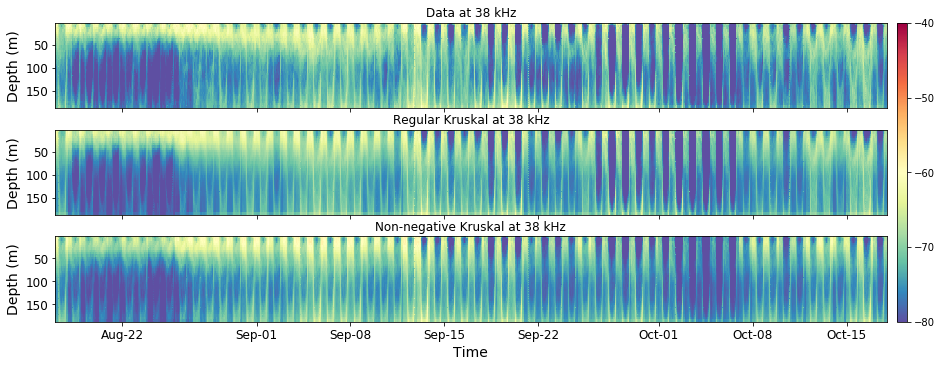

In [36]:
fig = compare_reconstruction(38000)
fig.savefig(os.path.join(fig_save_path,'recon_cmp_38kHz.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)

The patterns seem broadly similar, althought it is noticeable that the dark (low echo energy) patches are darker for regular Kruskal around Sep-26 to Oct-01.

### Full reconstruction comparison at 120 kHz

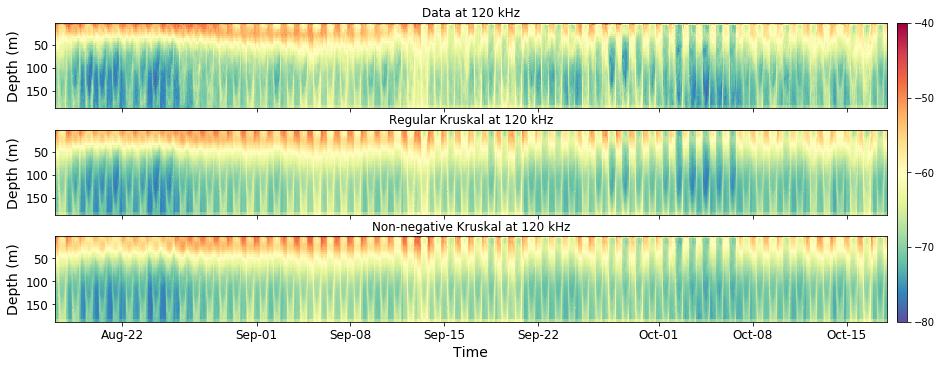

In [37]:
fig = compare_reconstruction(120000)
fig.savefig(os.path.join(fig_save_path,'recon_cmp_120kHz.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)

As in the 38 kHz reconstruction results, the darker patches around day 46-51 are darker for regular Kruskal.

### Full reconstruction comparison at 200 kHz

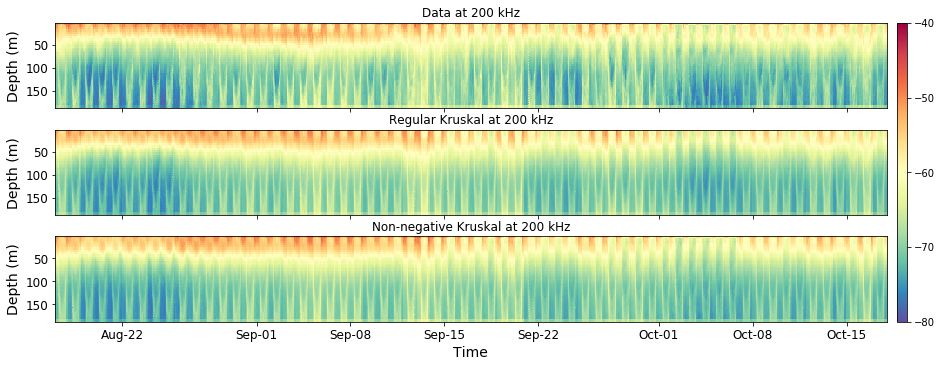

In [38]:
fig = compare_reconstruction(200000)
fig.savefig(os.path.join(fig_save_path,'recon_cmp_200kHz.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)            

## Check individual components

To figure out which factor corresponds to which dimension, let's check the size of the factors:

In [39]:
[fac.shape for fac in nonneg_3_rand.factors]

[(3, 3), (62, 3), (888, 3)]

We know that factor 0 corresponds with decomposition along `frequency`, factor 1 with `day of observation`, and factor 2 with `pixels in daily echogram`.

### Non-negative Kruskal decomposition:

In [40]:
nonneg_day_activation = xr.DataArray(
    nonneg_3_rand.factors[1].T, 
    coords=[('component', range(3)), ('date', pd.date_range('2015-08-17', periods=62))])

No handles with labels found to put in legend.


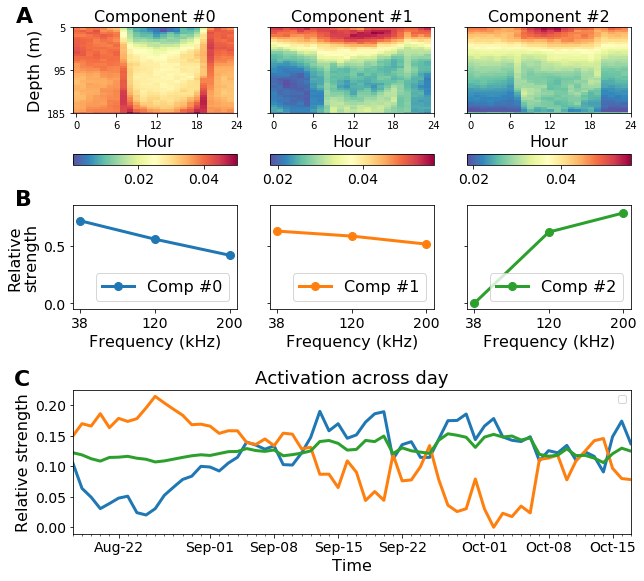

In [41]:
title_fontsize=16
axislabel_fontsize=16
ticklabel_fontsize=14
subfig_fontsize=22

freq_ylim = (-0.05, 0.85)


fig = plt.figure(figsize=(10,8))
gs_top = fig.add_gridspec(1,3, bottom=0.73)
gs_middle = fig.add_gridspec(1,3, top=0.57, bottom=0.39)
gs_bottom = fig.add_gridspec(1,1, bottom=0, top=0.25)


for ifac in range(3):

    # Daily echogram
    ax = fig.add_subplot(gs_top[0, ifac])
    im = ax.imshow(nonneg_3_rand.factors[2][:,ifac].reshape((37,24))[::-1,:],
                   aspect='auto',cmap='Spectral_r')
    ax.set_title('Component #%d'% ifac, fontsize=title_fontsize)
    ax.set_xticks(np.arange(0,25,6))
    ax.set_yticks(range(0,37,18))
    ax.set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
    ax.set_xlabel('Hour', fontsize=axislabel_fontsize)
    if ifac==0:
        ax.set_ylabel('Depth (m)', fontsize=axislabel_fontsize)
    else:
        ax.set_yticklabels('')
    ax.tick_params(labelsize=10)
    pos = ax.get_position()
    new_ax = [pos.x0, pos.y0-0.09]  # bottom-left starting point for color axis        
    cbar_ax = fig.add_axes([new_ax[0], new_ax[1], pos.width, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=ticklabel_fontsize)
    if ifac==0:
        fig.text(x=-0.35,y=1.05,s='A',transform=ax.transAxes, 
                 fontsize=subfig_fontsize, fontweight='bold')
    
    # Frequency
    ax = fig.add_subplot(gs_middle[0, ifac])
    ax.plot(nonneg_3_rand.factors[0][:,ifac],'o-', linewidth=3, 
            markersize=8, color='C%d'%ifac,
            label='Comp #%d'%ifac)
    ax.set_xticks(range(3))
    ax.set_xticklabels([38,120,200], fontsize=axislabel_fontsize)
    if ifac==0:
        ax.set_ylabel('Relative\nstrength', fontsize=axislabel_fontsize)
    else:
        ax.set_yticklabels('')
    ax.tick_params(labelsize=ticklabel_fontsize)
    ax.set_xlabel('Frequency (kHz)', fontsize=axislabel_fontsize)
    ax.set_ylim(freq_ylim)
    ax.legend(fontsize=axislabel_fontsize, loc='lower right')
    if ifac==0:
        fig.text(x=-0.35,y=1.00,s='B',transform=ax.transAxes, 
                 fontsize=subfig_fontsize, fontweight='bold')
    
# Activation
ax = fig.add_subplot(gs_bottom[0, :])
hl = nonneg_day_activation.plot.line(ax=ax, x='date', linewidth=3, label='')
ax.legend()  # have to call this to supress labels
ax.xaxis.set_minor_locator(mdates.DayLocator(range(0,32,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.tick_params(labelsize=ticklabel_fontsize)
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
ax.set_xlim([datetime.date(2015, 8, 17), datetime.date(2015, 10, 17)])
ax.set_title('Activation across day', fontsize=18)
ax.set_ylabel('Relative strength', fontsize=axislabel_fontsize)
ax.set_xlabel('Time',fontsize=axislabel_fontsize)    
fig.text(x=-0.106,y=1.03,s='C',transform=ax.transAxes, 
         fontsize=subfig_fontsize, fontweight='bold')

plt.subplots_adjust(hspace=0.5)

fig.savefig(os.path.join(fig_save_path,'components_all.png'),
        dpi=150, bbox_inches = 'tight', pad_inches = 0)

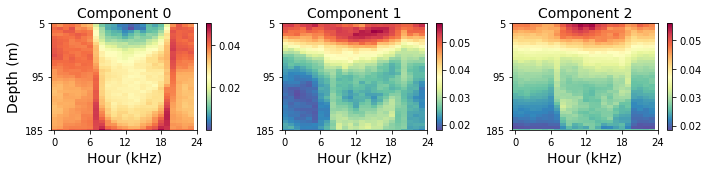

In [42]:
fig,ax = plt.subplots(1,3,figsize=(10,2.5))
for i in range(3):
    im = ax[i].imshow(nonneg_3_rand.factors[2][:,i].reshape((37,24))[::-1,:],
                      aspect='auto',cmap='Spectral_r')
    ax[i].set_title('Component %d'% i, fontsize=14)
    ax[i].set_xticks(np.arange(0,25,6))
    ax[i].set_yticks(range(0,37,18))
    ax[i].set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
    ax[i].set_xlabel('Hour (kHz)', fontsize=14)
    if ax[i].is_first_col():
        ax[i].set_ylabel('Depth (m)', fontsize=14)
    fig.colorbar(im, ax=ax[i])
plt.tight_layout()
plt.show()

fig.savefig(os.path.join(fig_save_path,'component_daily_echogram.png'), dpi=150)

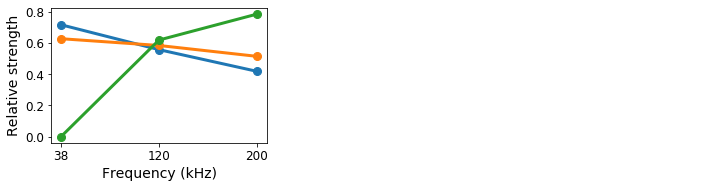

In [43]:
fig = plt.figure(figsize=(10,2.5), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(nonneg_3_rand.factors[0],'o-',linewidth=3,markersize=8)
ax1.set_xticks(range(3))
ax1.set_xticklabels([38,120,200], fontsize=12)
ax1.set_xlabel('Frequency (kHz)', fontsize=14)
ax1.set_ylabel('Relative strength', fontsize=14)
ax1.tick_params(labelsize=12)

fig.savefig(os.path.join(fig_save_path,'component_freq.png'), dpi=150)

No handles with labels found to put in legend.


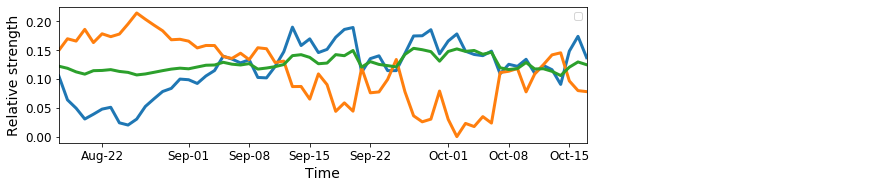

In [44]:
fig = plt.figure(figsize=(12,2.5), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax2 = fig.add_subplot(gs[0, :2])
hl = nonneg_day_activation.plot.line(ax=ax2, x='date', linewidth=3, label='')
ax2.legend()  # have to call this to supress labels
ax2.set_ylabel('Relative strength', fontsize=14)
ax2.set_xlabel('Time',fontsize=14)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax2.tick_params(labelsize=12)
plt.setp(ax2.get_xticklabels(), rotation=0, horizontalalignment='center')
ax2.set_xlim([datetime.date(2015, 8, 17), datetime.date(2015, 10, 17)])

plt.show()

fig.savefig(os.path.join(fig_save_path,'component_activation.png'), dpi=150)

## Combine pairs of factors

To get some intuition of what the individual components represent, here we do partial reconstruction of the components using only 2 out of the 3 dimensions.

In [45]:
import itertools

In [46]:
# Khatri-kao product to combine the factors
kr_nn_patterns = []
kr_nn_combs = []
for x,y in itertools.combinations(range(3),2):
    kr_nn_patterns.append((x,y))
    kr_nn_combs.append(khatri_rao((nonneg_3_rand.factors[x],nonneg_3_rand.factors[y])))

In [47]:
sonar_tensor.shape

(3, 62, 888)

In [48]:
kr_nn_patterns

[(0, 1), (0, 2), (1, 2)]

In [49]:
[x.shape for x in kr_nn_combs]

[(186, 3), (2664, 3), (55056, 3)]

In [50]:
37*24

888

In [51]:
888*62

55056

### Combine frequency and daily echogram pattern

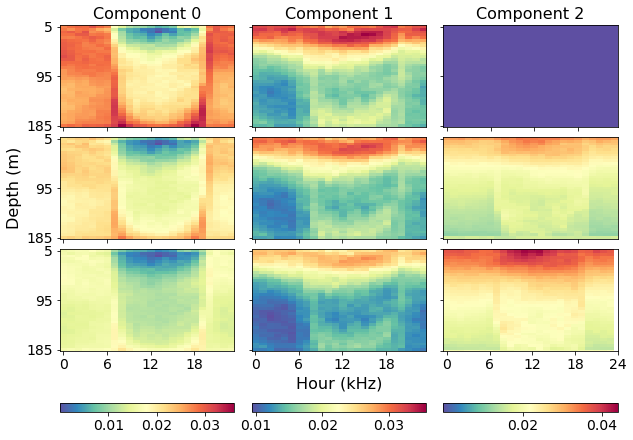

In [52]:
title_fontsize=16
axislabel_fontsize=16
ticklabel_fontsize=14
subfig_fontsize=22

fig,ax_all = plt.subplots(3,3,figsize=(10,6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for ifac in range(3):  # loop through factors
    # Get daily echogram pattern and value range
    fac_echogram = tl.unfold(tl.tensor(kr_nn_combs[1][:,ifac].reshape(3,37,24)[:,::-1,:]),mode=2).T
    zmax = fac_echogram.max()
    zmin = fac_echogram.min()
#     fac_echogram = (fac_echogram-zmin)/(zmax-zmin)
    for ifreq, freq in enumerate(frequency):    # loop through frequency
        ax = ax_all[ifreq, ifac]
        im = ax.imshow(fac_echogram[ifreq*37+np.arange(0,37,1),:],aspect='auto', vmax=zmax, vmin=zmin, 
                       cmap='Spectral_r')
        ax.set_yticks(range(0,37,18))
        ax.set_yticklabels((np.arange(0,37,18)+1)*depth_bin_size)
        ax.set_xticks(np.arange(0,25,6))
        if ifreq==0:
            ax.set_title('Component %d'% ifac, fontsize=title_fontsize)
        if ifac==0 and ifreq==1:
            ax.set_ylabel('Depth (m)', fontsize=axislabel_fontsize)
        ax.tick_params(labelsize=ticklabel_fontsize)
        if ifreq==2:
            pos = ax.get_position()
            new_ax = [pos.x0, pos.y0-0.14]  # bottom-left starting point for color axis        
            cbar_ax = fig.add_axes([new_ax[0], new_ax[1], pos.width, 0.02])  # [left, bottom, width, height]
            cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
            cbar_ax.tick_params(labelsize=ticklabel_fontsize)
            if ifac==1:
                ax.set_xlabel('Hour (kHz)', fontsize=axislabel_fontsize)
plt.show()

fig.savefig(os.path.join(fig_save_path,'combine_freq_daily_echogram.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)

### Combine frequency-dependent echogram pattern and day of activation

We combine the echogram pattern factors and their daily activation using Khatri-Rao product:

In [53]:
kr_nn_cube_all = khatri_rao((nonneg_3_rand.factors[0],
                             nonneg_3_rand.factors[1],
                             nonneg_3_rand.factors[2]))

Let's cehck the shapes of the combined factors and make sure we understand how to reshape them back to the partially reconstructed echograms we are looking for.

In [54]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [55]:
kr_nn_cube_all.shape

(165168, 3)

In [56]:
3*62*37*24

165168

In [57]:
kr_nn_cube_all_fac = [nonneg_3_rand.weights[comp]*kr_nn_cube_all[:,comp].reshape(L_sep_reduce.shape) 
                      for comp in range(3)]

In [58]:
kr_nn_cube_all_fac[0].shape

(3, 62, 37, 24)

We reconstruct DataArrays as before to facilitate plotting:

In [59]:
partial_38 = []
partial_120 = []
partial_200 = []
for fac in range(3):
    partial_38.append(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][0,:,:,:].squeeze()[:,::-1,:]),mode=1))
    partial_120.append(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][1,:,:,:].squeeze()[:,::-1,:]),mode=1))
    partial_200.append(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][2,:,:,:].squeeze()[:,::-1,:]),mode=1))

In [60]:
np.array(partial_38).shape

(3, 37, 1488)

In [61]:
partial_38 = xr.DataArray(np.array(partial_38), 
                    coords=[('component', range(3)), ('depth', depth), ('ping_time', p_time_reduce)])
partial_120 = xr.DataArray(np.array(partial_120), 
                    coords=[('component', range(3)), ('depth', depth), ('ping_time', p_time_reduce)])
partial_200 = xr.DataArray(np.array(partial_200), 
                    coords=[('component', range(3)), ('depth', depth), ('ping_time', p_time_reduce)])

Now we are ready to check how the factors are combined to form the long-term echogram at a particular frequency.

In [62]:
sonar_tensor.min()

-94.83359325945042

In [135]:
def check_partial_echogram(freq, partial):
    title_fontsize=16
    axislabel_fontsize=16
    ticklabel_fontsize=14
    subfig_fontsize=22

    fig = plt.figure(figsize=(10,8))
    gs_top = fig.add_gridspec(1,1, bottom=0.74)
    gs_middle = fig.add_gridspec(1,1, bottom=0.55, top=0.69)
    gs = fig.add_gridspec(3,1, bottom=0.04, top=0.5)

    # Data
    ax_data = fig.add_subplot(gs_top[0,0])
    im = MVBS_pcp_reduce.sel(frequency=freq).plot(ax=ax_data, cmap='Spectral_r', vmin=-40, vmax=-80,
                                    yincrease=False, add_colorbar=False)
    ax_data.set_title('Data at %d kHz' % (freq/1000), fontsize=title_fontsize)
    ax_data.set_xlabel('')
    ax_data.set_xticklabels('')
    ax_data.set_ylabel('Depth (m)', fontsize=axislabel_fontsize)
    ax_data.tick_params(labelsize=ticklabel_fontsize)
    ax_data.xaxis.set_minor_locator(mdates.DayLocator(range(0,32,1)))
    plt.setp(ax_data.get_xticklabels(), rotation=0, horizontalalignment='center')
    
    pos = ax_data.get_position()
    new_ax = [pos.x0+pos.width, pos.y0]  # bottom-left starting point for color axis        
    cbar_ax = fig.add_axes([new_ax[0]+0.012, new_ax[1], 0.01, 0.14])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)  
    cbar.set_ticks(range(-80,100,20))
    cbar.ax.tick_params(labelsize=ticklabel_fontsize)
    cbar.ax.set_ylabel('Sv (dB)', fontsize=ticklabel_fontsize)

    # Full reconstruction
    ax_recon = fig.add_subplot(gs_middle[0,0])
    im = recon_nonneg_3.sel(frequency=freq).plot(ax=ax_recon, vmin=-80, vmax=-40, cmap='Spectral_r', 
                                            add_colorbar=False, yincrease=False)
    ax_recon.set_title('Reconstruction at %d kHz' % (freq/1000), fontsize=title_fontsize)
    ax_recon.set_xlabel('')
    ax_recon.set_xticklabels('')
    ax_recon.set_ylabel('Depth (m)', fontsize=axislabel_fontsize)
    ax_recon.tick_params(labelsize=ticklabel_fontsize)
    ax_recon.xaxis.set_minor_locator(mdates.DayLocator(range(0,32,1)))
    plt.setp(ax_recon.get_xticklabels(), rotation=0, horizontalalignment='center')

    pos = ax_recon.get_position()
    new_ax = [pos.x0+pos.width, pos.y0]  # bottom-left starting point for color axis        
    cbar_ax = fig.add_axes([new_ax[0]+0.012, new_ax[1], 0.01, 0.14])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)  
    cbar.set_ticks(range(-80,100,20))
    cbar.ax.tick_params(labelsize=ticklabel_fontsize)
    cbar.ax.set_ylabel('Sv (dB)', fontsize=ticklabel_fontsize)

    
    # Partial reconstruction
    vmin = 0
    vmax = -40+95
    for ifac in range(3):
        ax = fig.add_subplot(gs[ifac,0])
        im = partial.sel(component=ifac).plot(ax=ax, cmap='Spectral_r', vmin=vmin, vmax=vmax,
                                         yincrease=False, add_colorbar=False)
        ax.tick_params(labelsize=ticklabel_fontsize)
        ax.xaxis.set_minor_locator(mdates.DayLocator(range(0,32,1)))
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title('')
        ax.set_xticklabels('')

        if ifac==0:
            ax.set_title('Components at %d kHz' % (freq/1000), fontsize=title_fontsize)
        if ifac==1:
            ax.set_ylabel('Depth (m)', fontsize=axislabel_fontsize)
        if ifac==2:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
            ax.set_xlabel('Time', fontsize=axislabel_fontsize)
            plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
            
        ax.annotate('Component %d'%ifac, 
                    xy=(0.015,0.15), xycoords='axes fraction', 
                    fontsize=ticklabel_fontsize, color='k', 
                    bbox=dict(facecolor='w', edgecolor=None, alpha=0.8))

    pos = ax.get_position()
    new_ax = [pos.x0+pos.width, pos.y0]  # bottom-left starting point for color axis        
    cbar_ax = fig.add_axes([new_ax[0]+0.012, new_ax[1]+0.06, 0.01, 0.34])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)  
    cbar.ax.tick_params(labelsize=ticklabel_fontsize)
    cbar.set_ticks(range(0,60,10))
    cbar.ax.set_ylabel('Relative strength', fontsize=ticklabel_fontsize)

    fig.subplots_adjust(hspace=0.1)
    plt.show()
    
    return fig

### Frequency-dependent component contribution at 38 kHz

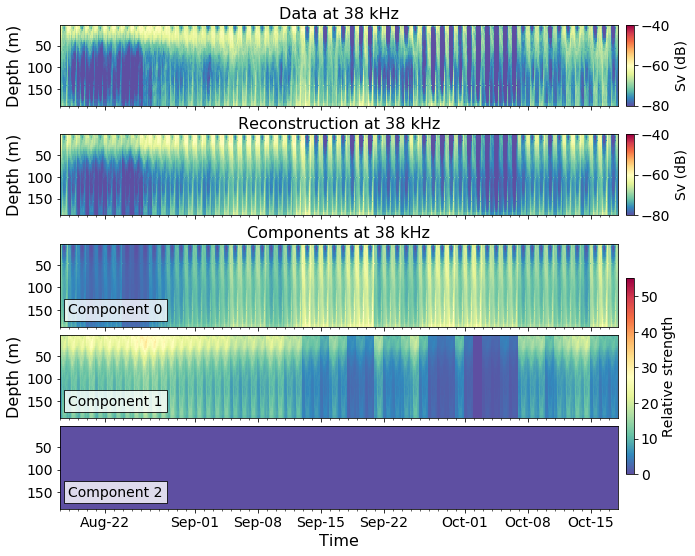

In [136]:
# Partial reconstruction at 38 kHz
fig = check_partial_echogram(38000, partial_38)
# fig.savefig(os.path.join(fig_save_path,'combine_all_38kHz.png'),
#             dpi=150, bbox_inches = 'tight', pad_inches = 0)

### Frequency-dependent component contribution at 120 kHz

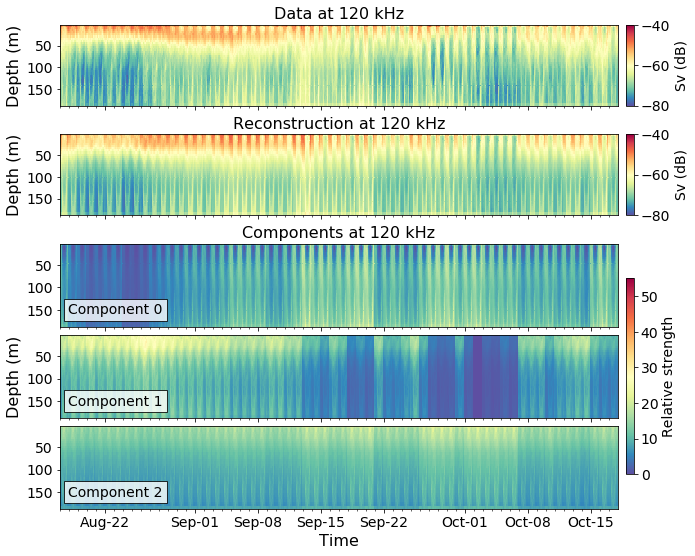

In [137]:
# Partial reconstruction at 120 kHz
fig = check_partial_echogram(120000, partial_120)
fig.savefig(os.path.join(fig_save_path,'combine_all_120kHz.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)

### Frequency-dependent component contribution at 200 kHz

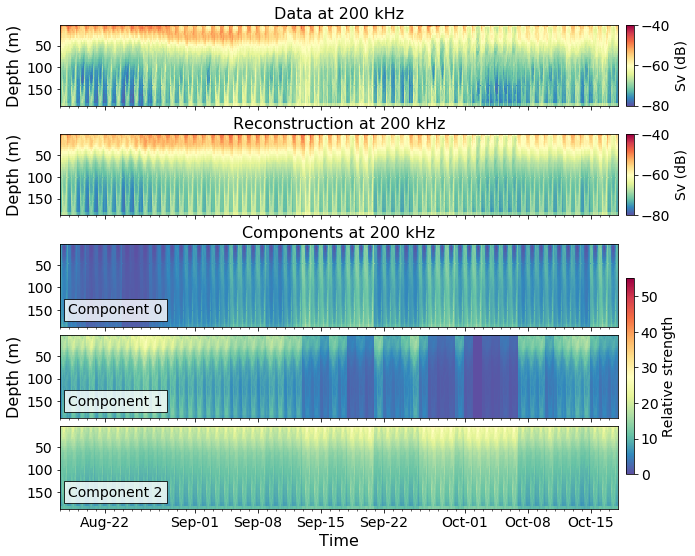

In [138]:
# Partial reconstruction at 200 kHz
fig = check_partial_echogram(200000, partial_200)
fig.savefig(os.path.join(fig_save_path,'combine_all_200kHz.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)